In [44]:
#deal with tensors
import numpy as np
import sklearn.metrics
import torch
import spacy
from torch.utils.data import random_split
from torchtext.legacy import data
import torchtext.vocab
import random
import helper.sklearn_to_csv
from sklearn import metrics

In [45]:
#Cuda algorithms
#torch.backends.cudnn.deterministic = True

In [46]:
# COL_OPINION = 0
# COL_SPEECH = 8
# TOTAL_COLS = 14
#
# RUNS = 100
# BATCH_SIZE = 16
# TEST_SPLIT = 0.15
# VALID_SPLIT = 0.15
# SHUFFLE = True
# STRATIFY = True
# CLASS_WEIGHTS = True
# REMOVE_STOP_WORDS = False
# STEMMING = False
# LOWERING = True
# NO_PUNCTUATION = False
#
# OUT_NAME = f'measures_lstm_01_{TEST_SPLIT}_{VALID_SPLIT}_Shuff{SHUFFLE}_Strat{STRATIFY}_Weigh{CLASS_WEIGHTS}_NoStop{REMOVE_STOP_WORDS}_Stem{STEMMING}_Low{LOWERING}_NoPun{NO_PUNCTUATION}'
# PATH_METRICS = f'../results/{OUT_NAME}.csv'
# PATH_DATASET = "../protocols/labelled/massnahmen_relevant.csv"
# PATH_PERFORMANCE_GRAPH = f'../results/{OUT_NAME}.png'
# PATH_WEIGHTS = '../saved_weights/lstm_01.pt'
#
# if not LOWERING:
#     raise Exception("Lower-casing must be enabled!")

In [47]:
COL_OPINION = 6
COL_SPEECH = 13
TOTAL_COLS = 14

RUNS = 100
BATCH_SIZE = 16
TEST_SPLIT = 0.15
VALID_SPLIT = 0.0
SHUFFLE = True
STRATIFY = True
CLASS_WEIGHTS = True
REMOVE_STOP_WORDS = False
STEMMING = False
LOWERING = True
NO_PUNCTUATION = False

OUT_NAME = f'lockdown_lstm_01_{TEST_SPLIT}_{VALID_SPLIT}_Shuff{SHUFFLE}_Strat{STRATIFY}_Weigh{CLASS_WEIGHTS}_NoStop{REMOVE_STOP_WORDS}_Stem{STEMMING}_Low{LOWERING}_NoPun{NO_PUNCTUATION}'
PATH_METRICS = f'../results/{OUT_NAME}.csv'
PATH_DATASET = "../protocols/labelled/only_lockdown.csv"
PATH_PERFORMANCE_GRAPH = f'../results/{OUT_NAME}.png'
PATH_WEIGHTS = f'../saved_weights/lstm_01_{OUT_NAME}.pt'

if not LOWERING:
    raise Exception("Lower-casing must be enabled!")

In [48]:
nlp = spacy.load("de_dep_news_trf")

In [49]:
TEXT = data.Field(tokenize='spacy',batch_first=True,include_lengths=True)
LABEL = data.LabelField(dtype = torch.float)
fields = [(None, None)] * TOTAL_COLS
fields[COL_OPINION] = ('label', LABEL)
fields[COL_SPEECH] = ('text',TEXT)



/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/torchtext/data/utils.py:123: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(f'Spacy model "{language}" could not be loaded, trying "{OLD_MODEL_SHORTCUTS[language]}" instead')


In [50]:
# loading custom dataset
training_data=data.TabularDataset(path = PATH_DATASET,format = 'csv',fields = fields,skip_header = True,
                                  csv_reader_params={'delimiter': '\t', 'quotechar': None})

In [51]:
all_samples = [e for e in training_data.examples]

In [52]:
# Pre-processing
# to lower case to match with vector embeddings
tmp = []
for sample in all_samples:
    text = getattr(sample, 'text')
    text = [s.lower() for s in text]
    setattr(sample, 'text', text)

In [53]:
#initialize glove embeddings
# the custom vectors we use in de_glove_deepsetai.txt have 300 dimensions
de_embeddings = torchtext.vocab.Vectors(name = '../vectors/de_glove_deepsetai.txt')
TEXT.build_vocab(training_data,min_freq=1,vectors = de_embeddings)
LABEL.build_vocab(training_data)

#No. of unique tokens in text
print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))

#Word dictionary
print(TEXT.vocab.stoi)

Size of TEXT vocabulary: 3384
Size of LABEL vocabulary: 3
[(',', 1345), ('die', 595), ('.', 508), ('der', 464), ('und', 457), ('lockdown', 380), ('\xa0', 310), ('in', 251), ('–', 211), ('den', 201)]
defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7f10e32374c0>>, {'<unk>': 0, '<pad>': 1, ',': 2, 'die': 3, '.': 4, 'der': 5, 'und': 6, 'lockdown': 7, '\xa0': 8, 'in': 9, '–': 10, 'den': 11, 'das': 12, 'es': 13, 'ist': 14, 'dass': 15, 'auch': 16, 'i': 17, 'm': 18, 'wir': 19, 'für': 20, 'des': 21, ':': 22, 'haben': 23, 'nicht': 24, 'hat': 25, 'sie': 26, 'zu': 27, 'von': 28, 'lockdowns': 29, 'sind': 30, 'dem': 31, 'ich': 32, 'mit': 33, '-': 34, 'zweiten': 35, 'eine': 36, 'ein': 37, 'einen': 38, 'noch': 39, 'jetzt': 40, 'wie': 41, 'aber': 42, 'wird': 43, 'sich': 44, 'vor': 45, 'werden': 46, 'auf': 47, 'um': 48, 'diese': 49, '„': 50, 'als': 51, 'so': 52, 'an': 53, 'durch': 54, 'am': 55, 'ja': 56, '“': 57, 'schon': 58, 'wieder': 59, 'wenn': 60, 'einem': 61

In [54]:
LABEL.vocab.stoi['-'] = 0
LABEL.vocab.stoi['o'] = 1
LABEL.vocab.stoi['+'] = 2
LABEL.vocab.itos = ['-', 'o', '+']

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [56]:
import torch.nn as nn

class classifier(nn.Module):

    #define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers,
                 bidirectional, dropout):

        #Constructor
        super().__init__()

        #embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        #lstm layer
        self.lstm = nn.LSTM(embedding_dim,
                           hidden_dim,
                           num_layers=n_layers,
                           bidirectional=bidirectional,
                           dropout=dropout,
                           batch_first=True)

        #dense layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

        #activation function
        self.act = nn.Sigmoid()

    def forward(self, text, text_lengths):

        #text = [batch size,sent_length]
        embedded = self.embedding(text)
        #embedded = [batch size, sent_len, emb dim]

        #packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)

        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]

        #concat the final forward and backward hidden state
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)

        #hidden = [batch size, hid dim * num directions]
        dense_outputs=self.fc(hidden)

        #Final activation function
        outputs=self.act(dense_outputs)

        return outputs

In [57]:
#define hyperparameters
size_of_vocab = len(TEXT.vocab)
embedding_dim = 300  # the custom vectors we use in de_glove_deepsetai.txt have 300 dimensions
num_hidden_nodes = 32
num_output_nodes = 3  # we have 3 different labels (-/o/+) so we need 3 output nodes.
num_layers = 2
bidirection = True
dropout = 0.2

#instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes,num_output_nodes, num_layers,
                   bidirectional = True, dropout = dropout)


In [58]:
import torch.optim as optim


#define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.argmax(preds, dim=-1)

    correct = (rounded_preds == y)
    acc = correct.sum() / len(correct)
    return acc



In [59]:
def train(model, iterator, optimizer, criterion):

    #initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    #set the model in training phase
    model.train()

    for batch in iterator:

        #resets the gradients after every batch
        optimizer.zero_grad()

        #retrieve text and no. of words
        text, text_lengths = batch.text

        # predictions has list of likelihoods for the 3 classes for each sample.
        predictions = model(text, text_lengths)

        #compute the loss
        loss = criterion(predictions, batch.label.type(torch.LongTensor))

        #compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label.type(torch.LongTensor))

        #backpropage the loss and compute the gradients
        loss.backward()

        #update the weights
        optimizer.step()

        #loss and accuracy
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [60]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    actual_labels = []
    predicted_labels = []
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths)
            actual_labels += batch.label.type(torch.LongTensor).tolist()
            predicted_labels += np.argmax(predictions, axis=-1).tolist()
            #compute loss and accuracy
            loss = criterion(predictions, batch.label.type(torch.LongTensor))
            acc = binary_accuracy(predictions, batch.label.type(torch.LongTensor))
            #keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator), metrics.classification_report(actual_labels, predicted_labels, output_dict=True)

In [61]:
def random_train_test_split(ds, split=1.0-TEST_SPLIT):
    positive = [e for e in ds if getattr(e, 'label') == '+']
    negative = [e for e in ds if getattr(e, 'label') == '-']
    neutral = [e for e in ds if getattr(e, 'label') == 'o']

    neg_train = int(len(negative) * split)
    neut_train = int(len(neutral) * split)
    pos_train = int(len(positive) * split)

    if SHUFFLE:
        random.shuffle(positive)
        random.shuffle(negative)
        random.shuffle(neutral)
    train_data = data.Dataset(positive[:pos_train] + negative[:neg_train] + neutral[:neut_train], fields)
    valid_data = data.Dataset(positive[pos_train:] + negative[neg_train:] + neutral[neut_train:], fields)

    return train_data, valid_data, neg_train, neut_train, pos_train

def create_iterators(train_data, test_data):
    train_iterator, valid_iterator = data.BucketIterator.splits(
        (train_data, test_data),
        batch_size = BATCH_SIZE,
        sort_key = lambda x: len(x.text),
        sort_within_batch=True,
        shuffle=True,
        device = device)
    return train_iterator, valid_iterator


N_EPOCHS = 10
runs = RUNS
accuracies = []

for run in range(runs):
    if VALID_SPLIT > 0:
        train_data, test_data, _, _, _ = random_train_test_split(all_samples, 1.0-TEST_SPLIT)
        split_train_, split_valid_, neg_train, neut_train, pos_train = random_train_test_split(train_data, 1.0-VALID_SPLIT)
    else:
        train_data, test_data, neg_train, neut_train, pos_train = random_train_test_split(all_samples, 1.0-TEST_SPLIT)
        split_valid_ = train_data
        split_train_ = train_data

    train_iterator, valid_iterator = create_iterators(split_train_, split_valid_)
    test_iterator = data.BucketIterator(test_data, BATCH_SIZE, train=False, sort_key = lambda x: len(x.text), device = device)

    model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes,num_output_nodes, num_layers,
                   bidirectional = True, dropout = dropout)
    #Initialize the pretrained embedding
    pretrained_embeddings = TEXT.vocab.vectors
    model.embedding.weight.data.copy_(pretrained_embeddings)
    #define optimizer and loss
    optimizer = optim.Adam(model.parameters())

    if CLASS_WEIGHTS:
        max_count = max([neg_train, neut_train, pos_train])
        criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor([max_count/float(neg_train), max_count/float(neut_train), max_count/float(pos_train)]))
    else:
        criterion = nn.CrossEntropyLoss()

    #push to cuda if available
    model = model.to(device)
    criterion = criterion.to(device)

    best_valid_loss = float('inf')
    best_valid_acc = 0.0
    for epoch in range(N_EPOCHS):
        train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
        valid_loss, valid_acc, classification_report = evaluate(model, valid_iterator, criterion)

        #save the best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_valid_acc = valid_acc
            torch.save(model.state_dict(), PATH_WEIGHTS)

        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    # load best model
    model.load_state_dict(torch.load(PATH_WEIGHTS))
    model.eval()
    test_loss, test_acc, classification_report = evaluate(model, test_iterator, criterion)
    helper.sklearn_to_csv.dict_to_csv(classification_report, PATH_METRICS)
    accuracies.append(test_acc)

/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.101 | Train Acc: 18.06%
	 Val. Loss: 1.095 |  Val. Acc: 37.73%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.091 | Train Acc: 56.25%
	 Val. Loss: 1.086 |  Val. Acc: 57.64%
	Train Loss: 1.076 | Train Acc: 58.56%
	 Val. Loss: 1.047 |  Val. Acc: 66.67%
	Train Loss: 1.005 | Train Acc: 68.52%
	 Val. Loss: 0.947 |  Val. Acc: 71.76%
	Train Loss: 0.915 | Train Acc: 75.69%
	 Val. Loss: 0.794 |  Val. Acc: 88.89%
	Train Loss: 0.753 | Train Acc: 90.97%
	 Val. Loss: 0.672 |  Val. Acc: 95.83%
	Train Loss: 0.643 | Train Acc: 96.99%
	 Val. Loss: 0.605 |  Val. Acc: 97.92%
	Train Loss: 0.600 | Train Acc: 98.61%
	 Val. Loss: 0.583 |  Val. Acc: 98.84%
	Train Loss: 0.581 | Train Acc: 98.61%
	 Val. Loss: 0.568 |  Val. Acc: 100.00%
	Train Loss: 0.569 | Train Acc: 100.00%
	 Val. Loss: 0.562 |  Val. Acc: 100.00%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.098 | Train Acc: 43.29%
	 Val. Loss: 1.092 |  Val. Acc: 58.10%
	Train Loss: 1.090 | Train Acc: 58.10%
	 Val. Loss: 1.076 |  Val. Acc: 59.49%
	Train Loss: 1.051 | Train Acc: 61.81%
	 Val. Loss: 1.000 |  Val. Acc: 73.38%
	Train Loss: 0.941 | Train Acc: 71.53%
	 Val. Loss: 0.886 |  Val. Acc: 70.14%
	Train Loss: 0.862 | Train Acc: 76.62%
	 Val. Loss: 0.763 |  Val. Acc: 89.58%
	Train Loss: 0.745 | Train Acc: 88.19%
	 Val. Loss: 0.680 |  Val. Acc: 93.52%
	Train Loss: 0.666 | Train Acc: 94.21%
	 Val. Loss: 0.638 |  Val. Acc: 96.06%
	Train Loss: 0.608 | Train Acc: 98.61%
	 Val. Loss: 0.582 |  Val. Acc: 100.00%
	Train Loss: 0.578 | Train Acc: 99.54%
	 Val. Loss: 0.572 |  Val. Acc: 99.77%
	Train Loss: 0.569 | Train Acc: 100.00%
	 Val. Loss: 0.564 |  Val. Acc: 100.00%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.101 | Train Acc: 31.71%
	 Val. Loss: 1.093 |  Val. Acc: 56.71%
	Train Loss: 1.091 | Train Acc: 57.41%
	 Val. Loss: 1.081 |  Val. Acc: 58.56%
	Train Loss: 1.068 | Train Acc: 60.19%
	 Val. Loss: 1.014 |  Val. Acc: 75.00%
	Train Loss: 0.968 | Train Acc: 71.99%
	 Val. Loss: 0.878 |  Val. Acc: 79.63%
	Train Loss: 0.849 | Train Acc: 80.79%
	 Val. Loss: 0.749 |  Val. Acc: 90.74%
	Train Loss: 0.715 | Train Acc: 92.13%
	 Val. Loss: 0.653 |  Val. Acc: 96.76%
	Train Loss: 0.632 | Train Acc: 96.30%
	 Val. Loss: 0.653 |  Val. Acc: 94.91%
	Train Loss: 0.601 | Train Acc: 98.38%
	 Val. Loss: 0.607 |  Val. Acc: 96.30%
	Train Loss: 0.597 | Train Acc: 97.22%
	 Val. Loss: 0.576 |  Val. Acc: 99.07%
	Train Loss: 0.576 | Train Acc: 99.31%
	 Val. Loss: 0.587 |  Val. Acc: 98.38%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.099 | Train Acc: 52.31%
	 Val. Loss: 1.093 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.093 | Train Acc: 57.64%
	 Val. Loss: 1.085 |  Val. Acc: 57.87%
	Train Loss: 1.077 | Train Acc: 59.03%
	 Val. Loss: 1.046 |  Val. Acc: 59.72%
	Train Loss: 1.009 | Train Acc: 67.82%
	 Val. Loss: 0.927 |  Val. Acc: 74.07%
	Train Loss: 0.889 | Train Acc: 73.38%
	 Val. Loss: 0.792 |  Val. Acc: 84.49%
	Train Loss: 0.754 | Train Acc: 86.11%
	 Val. Loss: 0.682 |  Val. Acc: 91.90%
	Train Loss: 0.657 | Train Acc: 94.21%
	 Val. Loss: 0.612 |  Val. Acc: 97.22%
	Train Loss: 0.606 | Train Acc: 97.92%
	 Val. Loss: 0.588 |  Val. Acc: 97.92%
	Train Loss: 0.585 | Train Acc: 98.38%
	 Val. Loss: 0.585 |  Val. Acc: 98.61%
	Train Loss: 0.579 | Train Acc: 98.84%
	 Val. Loss: 0.574 |  Val. Acc: 98.38%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.098 | Train Acc: 46.76%
	 Val. Loss: 1.092 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.090 | Train Acc: 57.64%
	 Val. Loss: 1.080 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.066 | Train Acc: 60.88%
	 Val. Loss: 1.023 |  Val. Acc: 64.35%
	Train Loss: 0.972 | Train Acc: 69.68%
	 Val. Loss: 0.865 |  Val. Acc: 83.10%
	Train Loss: 0.815 | Train Acc: 84.26%
	 Val. Loss: 0.742 |  Val. Acc: 90.97%
	Train Loss: 0.725 | Train Acc: 91.20%
	 Val. Loss: 0.652 |  Val. Acc: 96.76%
	Train Loss: 0.643 | Train Acc: 95.37%
	 Val. Loss: 0.599 |  Val. Acc: 99.07%
	Train Loss: 0.597 | Train Acc: 98.84%
	 Val. Loss: 0.588 |  Val. Acc: 98.61%
	Train Loss: 0.580 | Train Acc: 98.84%
	 Val. Loss: 0.579 |  Val. Acc: 98.84%
	Train Loss: 0.571 | Train Acc: 99.54%
	 Val. Loss: 0.564 |  Val. Acc: 99.77%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.098 | Train Acc: 51.16%
	 Val. Loss: 1.093 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.090 | Train Acc: 57.64%
	 Val. Loss: 1.081 |  Val. Acc: 57.64%
	Train Loss: 1.071 | Train Acc: 59.03%
	 Val. Loss: 1.029 |  Val. Acc: 71.76%
	Train Loss: 0.998 | Train Acc: 72.92%
	 Val. Loss: 0.926 |  Val. Acc: 83.56%
	Train Loss: 0.885 | Train Acc: 80.79%
	 Val. Loss: 0.802 |  Val. Acc: 92.36%
	Train Loss: 0.753 | Train Acc: 91.20%
	 Val. Loss: 0.674 |  Val. Acc: 96.76%
	Train Loss: 0.642 | Train Acc: 97.92%
	 Val. Loss: 0.617 |  Val. Acc: 98.15%
	Train Loss: 0.599 | Train Acc: 98.84%
	 Val. Loss: 0.581 |  Val. Acc: 99.77%
	Train Loss: 0.584 | Train Acc: 99.31%
	 Val. Loss: 0.571 |  Val. Acc: 99.77%
	Train Loss: 0.578 | Train Acc: 99.31%
	 Val. Loss: 0.567 |  Val. Acc: 99.77%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.100 | Train Acc: 44.44%
	 Val. Loss: 1.093 |  Val. Acc: 58.10%
	Train Loss: 1.093 | Train Acc: 59.03%
	 Val. Loss: 1.086 |  Val. Acc: 60.42%
	Train Loss: 1.078 | Train Acc: 61.57%
	 Val. Loss: 1.044 |  Val. Acc: 63.66%
	Train Loss: 1.006 | Train Acc: 66.20%
	 Val. Loss: 0.917 |  Val. Acc: 75.93%
	Train Loss: 0.857 | Train Acc: 81.71%
	 Val. Loss: 0.795 |  Val. Acc: 86.57%
	Train Loss: 0.725 | Train Acc: 89.58%
	 Val. Loss: 0.689 |  Val. Acc: 89.12%
	Train Loss: 0.654 | Train Acc: 93.98%
	 Val. Loss: 0.597 |  Val. Acc: 98.84%
	Train Loss: 0.604 | Train Acc: 97.45%
	 Val. Loss: 0.587 |  Val. Acc: 98.38%
	Train Loss: 0.585 | Train Acc: 98.15%
	 Val. Loss: 0.592 |  Val. Acc: 96.53%
	Train Loss: 0.589 | Train Acc: 96.76%
	 Val. Loss: 0.573 |  Val. Acc: 99.07%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.098 | Train Acc: 57.64%
	 Val. Loss: 1.093 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.091 | Train Acc: 57.64%
	 Val. Loss: 1.083 |  Val. Acc: 59.72%
	Train Loss: 1.073 | Train Acc: 58.80%
	 Val. Loss: 1.022 |  Val. Acc: 69.68%
	Train Loss: 0.969 | Train Acc: 74.54%
	 Val. Loss: 0.887 |  Val. Acc: 71.30%
	Train Loss: 0.873 | Train Acc: 75.46%
	 Val. Loss: 0.788 |  Val. Acc: 92.59%
	Train Loss: 0.753 | Train Acc: 87.96%
	 Val. Loss: 0.681 |  Val. Acc: 92.36%
	Train Loss: 0.678 | Train Acc: 91.20%
	 Val. Loss: 0.633 |  Val. Acc: 98.61%
	Train Loss: 0.616 | Train Acc: 97.92%
	 Val. Loss: 0.589 |  Val. Acc: 99.31%
	Train Loss: 0.586 | Train Acc: 99.31%
	 Val. Loss: 0.574 |  Val. Acc: 99.77%
	Train Loss: 0.572 | Train Acc: 99.77%
	 Val. Loss: 0.569 |  Val. Acc: 99.77%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.099 | Train Acc: 34.72%
	 Val. Loss: 1.093 |  Val. Acc: 59.72%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.092 | Train Acc: 59.72%
	 Val. Loss: 1.079 |  Val. Acc: 59.72%
	Train Loss: 1.066 | Train Acc: 63.19%
	 Val. Loss: 1.015 |  Val. Acc: 66.20%
	Train Loss: 0.965 | Train Acc: 74.07%
	 Val. Loss: 0.847 |  Val. Acc: 86.11%
	Train Loss: 0.821 | Train Acc: 84.26%
	 Val. Loss: 0.728 |  Val. Acc: 91.20%
	Train Loss: 0.686 | Train Acc: 94.68%
	 Val. Loss: 0.630 |  Val. Acc: 98.15%
	Train Loss: 0.624 | Train Acc: 97.92%
	 Val. Loss: 0.608 |  Val. Acc: 98.38%
	Train Loss: 0.614 | Train Acc: 97.92%
	 Val. Loss: 0.592 |  Val. Acc: 98.61%
	Train Loss: 0.582 | Train Acc: 99.54%
	 Val. Loss: 0.569 |  Val. Acc: 100.00%
	Train Loss: 0.569 | Train Acc: 100.00%
	 Val. Loss: 0.573 |  Val. Acc: 98.84%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.098 | Train Acc: 56.25%
	 Val. Loss: 1.093 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.092 | Train Acc: 57.64%
	 Val. Loss: 1.083 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.072 | Train Acc: 59.95%
	 Val. Loss: 1.030 |  Val. Acc: 65.05%
	Train Loss: 0.980 | Train Acc: 65.74%
	 Val. Loss: 0.880 |  Val. Acc: 80.79%
	Train Loss: 0.834 | Train Acc: 83.33%
	 Val. Loss: 0.730 |  Val. Acc: 91.20%
	Train Loss: 0.702 | Train Acc: 93.29%
	 Val. Loss: 0.669 |  Val. Acc: 96.76%
	Train Loss: 0.644 | Train Acc: 95.83%
	 Val. Loss: 0.594 |  Val. Acc: 100.00%
	Train Loss: 0.587 | Train Acc: 99.31%
	 Val. Loss: 0.578 |  Val. Acc: 99.31%
	Train Loss: 0.574 | Train Acc: 99.77%
	 Val. Loss: 0.571 |  Val. Acc: 99.77%
	Train Loss: 0.569 | Train Acc: 99.77%
	 Val. Loss: 0.564 |  Val. Acc: 99.77%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.099 | Train Acc: 57.18%
	 Val. Loss: 1.093 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.093 | Train Acc: 57.64%
	 Val. Loss: 1.086 |  Val. Acc: 57.64%
	Train Loss: 1.080 | Train Acc: 58.56%
	 Val. Loss: 1.051 |  Val. Acc: 68.29%
	Train Loss: 0.998 | Train Acc: 75.93%
	 Val. Loss: 0.889 |  Val. Acc: 84.03%
	Train Loss: 0.843 | Train Acc: 84.95%
	 Val. Loss: 0.730 |  Val. Acc: 96.76%
	Train Loss: 0.719 | Train Acc: 93.29%
	 Val. Loss: 0.639 |  Val. Acc: 97.22%
	Train Loss: 0.627 | Train Acc: 97.45%
	 Val. Loss: 0.619 |  Val. Acc: 98.38%
	Train Loss: 0.595 | Train Acc: 99.07%
	 Val. Loss: 0.578 |  Val. Acc: 100.00%
	Train Loss: 0.573 | Train Acc: 99.77%
	 Val. Loss: 0.566 |  Val. Acc: 100.00%
	Train Loss: 0.567 | Train Acc: 100.00%
	 Val. Loss: 0.562 |  Val. Acc: 100.00%
	Train Loss: 1.097 | Train Acc: 49.07%
	 Val. Loss: 1.090 |  Val. Acc: 60.42%
	Train Loss: 1.086 | Train Acc: 59.49%
	 Val. Loss: 1.072 |  Val. Acc: 60.88%
	Train Loss: 1.056 | Train Acc: 62.50%
	 Val. Loss: 0.993 |  Val. Acc: 76.62%
	Train Loss: 0.947 | Train Acc: 76.85%
	 Val. Loss: 0.851 | 

/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.099 | Train Acc: 30.79%
	 Val. Loss: 1.093 |  Val. Acc: 60.88%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.090 | Train Acc: 60.19%
	 Val. Loss: 1.079 |  Val. Acc: 59.03%
	Train Loss: 1.063 | Train Acc: 62.04%
	 Val. Loss: 1.007 |  Val. Acc: 75.69%
	Train Loss: 0.974 | Train Acc: 72.45%
	 Val. Loss: 0.873 |  Val. Acc: 83.10%
	Train Loss: 0.795 | Train Acc: 87.73%
	 Val. Loss: 0.713 |  Val. Acc: 88.89%
	Train Loss: 0.706 | Train Acc: 87.50%
	 Val. Loss: 0.637 |  Val. Acc: 95.60%
	Train Loss: 0.628 | Train Acc: 96.30%
	 Val. Loss: 0.600 |  Val. Acc: 97.45%
	Train Loss: 0.584 | Train Acc: 98.61%
	 Val. Loss: 0.574 |  Val. Acc: 99.07%
	Train Loss: 0.573 | Train Acc: 99.07%
	 Val. Loss: 0.566 |  Val. Acc: 99.07%
	Train Loss: 0.564 | Train Acc: 99.54%
	 Val. Loss: 0.561 |  Val. Acc: 99.54%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.099 | Train Acc: 42.82%
	 Val. Loss: 1.093 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.092 | Train Acc: 57.64%
	 Val. Loss: 1.083 |  Val. Acc: 57.64%
	Train Loss: 1.078 | Train Acc: 62.04%
	 Val. Loss: 1.052 |  Val. Acc: 65.51%
	Train Loss: 1.008 | Train Acc: 70.37%
	 Val. Loss: 0.892 |  Val. Acc: 81.02%
	Train Loss: 0.840 | Train Acc: 82.87%
	 Val. Loss: 0.723 |  Val. Acc: 90.51%
	Train Loss: 0.691 | Train Acc: 93.98%
	 Val. Loss: 0.647 |  Val. Acc: 93.52%
	Train Loss: 0.622 | Train Acc: 98.15%
	 Val. Loss: 0.600 |  Val. Acc: 98.15%
	Train Loss: 0.593 | Train Acc: 98.61%
	 Val. Loss: 0.574 |  Val. Acc: 99.31%
	Train Loss: 0.602 | Train Acc: 96.06%
	 Val. Loss: 0.600 |  Val. Acc: 98.15%
	Train Loss: 0.581 | Train Acc: 99.31%
	 Val. Loss: 0.571 |  Val. Acc: 99.31%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.099 | Train Acc: 53.24%
	 Val. Loss: 1.093 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.092 | Train Acc: 57.64%
	 Val. Loss: 1.083 |  Val. Acc: 57.64%
	Train Loss: 1.076 | Train Acc: 58.10%
	 Val. Loss: 1.046 |  Val. Acc: 61.11%
	Train Loss: 1.001 | Train Acc: 66.44%
	 Val. Loss: 0.964 |  Val. Acc: 76.85%
	Train Loss: 0.868 | Train Acc: 80.79%
	 Val. Loss: 0.752 |  Val. Acc: 92.13%
	Train Loss: 0.719 | Train Acc: 91.67%
	 Val. Loss: 0.648 |  Val. Acc: 96.76%
	Train Loss: 0.624 | Train Acc: 98.61%
	 Val. Loss: 0.594 |  Val. Acc: 99.54%
	Train Loss: 0.591 | Train Acc: 99.54%
	 Val. Loss: 0.578 |  Val. Acc: 99.54%
	Train Loss: 0.575 | Train Acc: 99.77%
	 Val. Loss: 0.566 |  Val. Acc: 99.77%
	Train Loss: 0.564 | Train Acc: 99.77%
	 Val. Loss: 0.561 |  Val. Acc: 99.77%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.098 | Train Acc: 57.41%
	 Val. Loss: 1.092 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.091 | Train Acc: 57.64%
	 Val. Loss: 1.084 |  Val. Acc: 57.87%
	Train Loss: 1.076 | Train Acc: 59.72%
	 Val. Loss: 1.044 |  Val. Acc: 73.61%
	Train Loss: 0.994 | Train Acc: 72.22%
	 Val. Loss: 0.870 |  Val. Acc: 85.88%
	Train Loss: 0.826 | Train Acc: 85.88%
	 Val. Loss: 0.722 |  Val. Acc: 93.52%
	Train Loss: 0.709 | Train Acc: 94.21%
	 Val. Loss: 0.631 |  Val. Acc: 98.61%
	Train Loss: 0.627 | Train Acc: 96.53%
	 Val. Loss: 0.593 |  Val. Acc: 99.54%
	Train Loss: 0.586 | Train Acc: 99.07%
	 Val. Loss: 0.577 |  Val. Acc: 99.31%
	Train Loss: 0.574 | Train Acc: 99.54%
	 Val. Loss: 0.567 |  Val. Acc: 99.77%
	Train Loss: 0.566 | Train Acc: 99.77%
	 Val. Loss: 0.563 |  Val. Acc: 99.77%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.098 | Train Acc: 52.08%
	 Val. Loss: 1.093 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.092 | Train Acc: 57.64%
	 Val. Loss: 1.083 |  Val. Acc: 57.64%
	Train Loss: 1.078 | Train Acc: 58.80%
	 Val. Loss: 1.043 |  Val. Acc: 63.66%
	Train Loss: 1.001 | Train Acc: 68.52%
	 Val. Loss: 0.890 |  Val. Acc: 82.87%
	Train Loss: 0.833 | Train Acc: 85.19%
	 Val. Loss: 0.738 |  Val. Acc: 92.82%
	Train Loss: 0.715 | Train Acc: 89.35%
	 Val. Loss: 0.687 |  Val. Acc: 93.98%
	Train Loss: 0.659 | Train Acc: 95.14%
	 Val. Loss: 0.605 |  Val. Acc: 98.38%
	Train Loss: 0.607 | Train Acc: 97.92%
	 Val. Loss: 0.584 |  Val. Acc: 98.84%
	Train Loss: 0.583 | Train Acc: 98.84%
	 Val. Loss: 0.571 |  Val. Acc: 99.07%
	Train Loss: 0.574 | Train Acc: 98.84%
	 Val. Loss: 0.566 |  Val. Acc: 99.77%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.100 | Train Acc: 28.24%
	 Val. Loss: 1.094 |  Val. Acc: 59.03%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.093 | Train Acc: 58.33%
	 Val. Loss: 1.084 |  Val. Acc: 57.87%
	Train Loss: 1.076 | Train Acc: 59.49%
	 Val. Loss: 1.044 |  Val. Acc: 70.83%
	Train Loss: 1.003 | Train Acc: 68.75%
	 Val. Loss: 0.929 |  Val. Acc: 73.15%
	Train Loss: 0.857 | Train Acc: 81.25%
	 Val. Loss: 0.745 |  Val. Acc: 91.20%
	Train Loss: 0.718 | Train Acc: 90.28%
	 Val. Loss: 0.636 |  Val. Acc: 98.15%
	Train Loss: 0.618 | Train Acc: 97.45%
	 Val. Loss: 0.589 |  Val. Acc: 98.84%
	Train Loss: 0.581 | Train Acc: 99.31%
	 Val. Loss: 0.571 |  Val. Acc: 99.77%
	Train Loss: 0.568 | Train Acc: 100.00%
	 Val. Loss: 0.563 |  Val. Acc: 100.00%
	Train Loss: 0.563 | Train Acc: 100.00%
	 Val. Loss: 0.560 |  Val. Acc: 100.00%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.098 | Train Acc: 56.94%
	 Val. Loss: 1.092 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.092 | Train Acc: 57.87%
	 Val. Loss: 1.084 |  Val. Acc: 57.64%
	Train Loss: 1.078 | Train Acc: 58.33%
	 Val. Loss: 1.048 |  Val. Acc: 71.30%
	Train Loss: 1.013 | Train Acc: 70.83%
	 Val. Loss: 0.933 |  Val. Acc: 84.95%
	Train Loss: 0.863 | Train Acc: 86.57%
	 Val. Loss: 0.741 |  Val. Acc: 92.82%
	Train Loss: 0.696 | Train Acc: 95.37%
	 Val. Loss: 0.635 |  Val. Acc: 97.69%
	Train Loss: 0.621 | Train Acc: 97.45%
	 Val. Loss: 0.590 |  Val. Acc: 99.07%
	Train Loss: 0.602 | Train Acc: 98.84%
	 Val. Loss: 0.587 |  Val. Acc: 99.54%
	Train Loss: 0.581 | Train Acc: 99.77%
	 Val. Loss: 0.570 |  Val. Acc: 99.77%
	Train Loss: 0.571 | Train Acc: 99.77%
	 Val. Loss: 0.564 |  Val. Acc: 99.77%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.098 | Train Acc: 57.64%
	 Val. Loss: 1.093 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.091 | Train Acc: 57.64%
	 Val. Loss: 1.081 |  Val. Acc: 57.64%
	Train Loss: 1.068 | Train Acc: 60.19%
	 Val. Loss: 1.019 |  Val. Acc: 70.37%
	Train Loss: 0.973 | Train Acc: 73.84%
	 Val. Loss: 0.899 |  Val. Acc: 87.73%
	Train Loss: 0.838 | Train Acc: 87.96%
	 Val. Loss: 0.737 |  Val. Acc: 92.82%
	Train Loss: 0.729 | Train Acc: 92.13%
	 Val. Loss: 0.665 |  Val. Acc: 96.30%
	Train Loss: 0.654 | Train Acc: 95.37%
	 Val. Loss: 0.641 |  Val. Acc: 95.83%
	Train Loss: 0.605 | Train Acc: 97.22%
	 Val. Loss: 0.613 |  Val. Acc: 98.38%
	Train Loss: 0.588 | Train Acc: 99.07%
	 Val. Loss: 0.574 |  Val. Acc: 99.77%
	Train Loss: 0.570 | Train Acc: 100.00%
	 Val. Loss: 0.565 |  Val. Acc: 100.00%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.098 | Train Acc: 57.41%
	 Val. Loss: 1.093 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.092 | Train Acc: 57.64%
	 Val. Loss: 1.086 |  Val. Acc: 57.64%
	Train Loss: 1.078 | Train Acc: 58.10%
	 Val. Loss: 1.047 |  Val. Acc: 59.95%
	Train Loss: 1.008 | Train Acc: 66.20%
	 Val. Loss: 0.910 |  Val. Acc: 78.01%
	Train Loss: 0.880 | Train Acc: 78.01%
	 Val. Loss: 0.772 |  Val. Acc: 89.81%
	Train Loss: 0.726 | Train Acc: 92.13%
	 Val. Loss: 0.651 |  Val. Acc: 96.06%
	Train Loss: 0.657 | Train Acc: 95.83%
	 Val. Loss: 0.628 |  Val. Acc: 96.53%
	Train Loss: 0.611 | Train Acc: 96.76%
	 Val. Loss: 0.583 |  Val. Acc: 99.31%
	Train Loss: 0.576 | Train Acc: 99.77%
	 Val. Loss: 0.569 |  Val. Acc: 100.00%
	Train Loss: 0.566 | Train Acc: 100.00%
	 Val. Loss: 0.563 |  Val. Acc: 100.00%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.099 | Train Acc: 34.26%
	 Val. Loss: 1.094 |  Val. Acc: 60.19%
	Train Loss: 1.093 | Train Acc: 57.64%
	 Val. Loss: 1.085 |  Val. Acc: 58.80%
	Train Loss: 1.078 | Train Acc: 59.49%
	 Val. Loss: 1.040 |  Val. Acc: 67.82%
	Train Loss: 1.008 | Train Acc: 68.75%
	 Val. Loss: 0.920 |  Val. Acc: 80.56%
	Train Loss: 0.860 | Train Acc: 81.94%
	 Val. Loss: 0.737 |  Val. Acc: 92.82%
	Train Loss: 0.717 | Train Acc: 90.97%
	 Val. Loss: 0.641 |  Val. Acc: 97.22%
	Train Loss: 0.637 | Train Acc: 97.45%
	 Val. Loss: 0.600 |  Val. Acc: 98.84%
	Train Loss: 0.600 | Train Acc: 97.45%
	 Val. Loss: 0.582 |  Val. Acc: 98.61%
	Train Loss: 0.577 | Train Acc: 99.31%
	 Val. Loss: 0.569 |  Val. Acc: 99.77%
	Train Loss: 0.567 | Train Acc: 99.54%
	 Val. Loss: 0.563 |  Val. Acc: 100.00%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.100 | Train Acc: 44.68%
	 Val. Loss: 1.094 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.094 | Train Acc: 57.64%
	 Val. Loss: 1.087 |  Val. Acc: 57.64%
	Train Loss: 1.081 | Train Acc: 58.33%
	 Val. Loss: 1.054 |  Val. Acc: 65.97%
	Train Loss: 1.014 | Train Acc: 69.44%
	 Val. Loss: 0.901 |  Val. Acc: 86.81%
	Train Loss: 0.859 | Train Acc: 79.40%
	 Val. Loss: 0.753 |  Val. Acc: 93.75%
	Train Loss: 0.710 | Train Acc: 93.52%
	 Val. Loss: 0.652 |  Val. Acc: 96.99%
	Train Loss: 0.625 | Train Acc: 97.45%
	 Val. Loss: 0.597 |  Val. Acc: 99.07%
	Train Loss: 0.595 | Train Acc: 98.38%
	 Val. Loss: 0.577 |  Val. Acc: 99.54%
	Train Loss: 0.586 | Train Acc: 98.61%
	 Val. Loss: 0.582 |  Val. Acc: 99.07%
	Train Loss: 0.571 | Train Acc: 99.54%
	 Val. Loss: 0.564 |  Val. Acc: 99.77%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.098 | Train Acc: 57.64%
	 Val. Loss: 1.093 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.092 | Train Acc: 57.64%
	 Val. Loss: 1.085 |  Val. Acc: 57.64%
	Train Loss: 1.080 | Train Acc: 57.87%
	 Val. Loss: 1.051 |  Val. Acc: 63.43%
	Train Loss: 1.018 | Train Acc: 69.21%
	 Val. Loss: 0.912 |  Val. Acc: 84.49%
	Train Loss: 0.871 | Train Acc: 83.80%
	 Val. Loss: 0.761 |  Val. Acc: 92.36%
	Train Loss: 0.716 | Train Acc: 94.91%
	 Val. Loss: 0.640 |  Val. Acc: 96.99%
	Train Loss: 0.632 | Train Acc: 97.69%
	 Val. Loss: 0.603 |  Val. Acc: 99.07%
	Train Loss: 0.600 | Train Acc: 98.84%
	 Val. Loss: 0.575 |  Val. Acc: 99.77%
	Train Loss: 0.577 | Train Acc: 99.31%
	 Val. Loss: 0.569 |  Val. Acc: 99.77%
	Train Loss: 0.566 | Train Acc: 100.00%
	 Val. Loss: 0.561 |  Val. Acc: 100.00%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.101 | Train Acc: 18.06%
	 Val. Loss: 1.095 |  Val. Acc: 29.63%
	Train Loss: 1.094 | Train Acc: 52.08%
	 Val. Loss: 1.088 |  Val. Acc: 60.65%
	Train Loss: 1.080 | Train Acc: 61.34%
	 Val. Loss: 1.051 |  Val. Acc: 61.11%
	Train Loss: 1.009 | Train Acc: 70.60%
	 Val. Loss: 0.937 |  Val. Acc: 77.55%
	Train Loss: 0.880 | Train Acc: 78.70%
	 Val. Loss: 0.792 |  Val. Acc: 90.28%
	Train Loss: 0.743 | Train Acc: 91.44%
	 Val. Loss: 0.677 |  Val. Acc: 96.30%
	Train Loss: 0.663 | Train Acc: 95.60%
	 Val. Loss: 0.630 |  Val. Acc: 96.53%
	Train Loss: 0.595 | Train Acc: 99.07%
	 Val. Loss: 0.596 |  Val. Acc: 98.15%
	Train Loss: 0.578 | Train Acc: 99.07%
	 Val. Loss: 0.568 |  Val. Acc: 99.77%
	Train Loss: 0.570 | Train Acc: 99.77%
	 Val. Loss: 0.563 |  Val. Acc: 100.00%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.099 | Train Acc: 48.61%
	 Val. Loss: 1.092 |  Val. Acc: 58.56%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.090 | Train Acc: 58.80%
	 Val. Loss: 1.080 |  Val. Acc: 58.80%
	Train Loss: 1.073 | Train Acc: 60.42%
	 Val. Loss: 1.039 |  Val. Acc: 75.00%
	Train Loss: 1.016 | Train Acc: 68.75%
	 Val. Loss: 0.927 |  Val. Acc: 82.64%
	Train Loss: 0.886 | Train Acc: 81.71%
	 Val. Loss: 0.773 |  Val. Acc: 92.13%
	Train Loss: 0.745 | Train Acc: 93.29%
	 Val. Loss: 0.652 |  Val. Acc: 98.84%
	Train Loss: 0.637 | Train Acc: 97.92%
	 Val. Loss: 0.598 |  Val. Acc: 99.54%
	Train Loss: 0.590 | Train Acc: 99.54%
	 Val. Loss: 0.575 |  Val. Acc: 99.54%
	Train Loss: 0.573 | Train Acc: 100.00%
	 Val. Loss: 0.566 |  Val. Acc: 100.00%
	Train Loss: 0.566 | Train Acc: 99.77%
	 Val. Loss: 0.566 |  Val. Acc: 100.00%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.099 | Train Acc: 39.35%
	 Val. Loss: 1.092 |  Val. Acc: 58.33%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.090 | Train Acc: 58.10%
	 Val. Loss: 1.079 |  Val. Acc: 57.87%
	Train Loss: 1.070 | Train Acc: 61.34%
	 Val. Loss: 1.027 |  Val. Acc: 64.35%
	Train Loss: 0.973 | Train Acc: 74.31%
	 Val. Loss: 0.894 |  Val. Acc: 78.01%
	Train Loss: 0.810 | Train Acc: 85.65%
	 Val. Loss: 0.801 |  Val. Acc: 76.85%
	Train Loss: 0.697 | Train Acc: 92.36%
	 Val. Loss: 0.633 |  Val. Acc: 97.92%
	Train Loss: 0.619 | Train Acc: 96.99%
	 Val. Loss: 0.619 |  Val. Acc: 95.83%
	Train Loss: 0.599 | Train Acc: 98.15%
	 Val. Loss: 0.583 |  Val. Acc: 99.54%
	Train Loss: 0.579 | Train Acc: 99.54%
	 Val. Loss: 0.570 |  Val. Acc: 99.54%
	Train Loss: 0.569 | Train Acc: 99.54%
	 Val. Loss: 0.565 |  Val. Acc: 99.54%
	Train Loss: 1.099 | Train Acc: 28.24%
	 Val. Loss: 1.093 |  Val. Acc: 62.04%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.091 | Train Acc: 57.87%
	 Val. Loss: 1.081 |  Val. Acc: 57.87%
	Train Loss: 1.071 | Train Acc: 60.65%
	 Val. Loss: 1.024 |  Val. Acc: 73.61%
	Train Loss: 0.977 | Train Acc: 74.31%
	 Val. Loss: 0.872 |  Val. Acc: 84.03%
	Train Loss: 0.852 | Train Acc: 81.02%
	 Val. Loss: 0.761 |  Val. Acc: 93.75%
	Train Loss: 0.722 | Train Acc: 94.44%
	 Val. Loss: 0.645 |  Val. Acc: 97.69%
	Train Loss: 0.634 | Train Acc: 96.76%
	 Val. Loss: 0.601 |  Val. Acc: 99.07%
	Train Loss: 0.597 | Train Acc: 98.61%
	 Val. Loss: 0.580 |  Val. Acc: 99.54%
	Train Loss: 0.576 | Train Acc: 99.54%
	 Val. Loss: 0.567 |  Val. Acc: 99.77%
	Train Loss: 0.566 | Train Acc: 99.77%
	 Val. Loss: 0.563 |  Val. Acc: 100.00%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.100 | Train Acc: 43.29%
	 Val. Loss: 1.093 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.093 | Train Acc: 57.41%
	 Val. Loss: 1.088 |  Val. Acc: 57.64%
	Train Loss: 1.076 | Train Acc: 59.72%
	 Val. Loss: 1.047 |  Val. Acc: 62.73%
	Train Loss: 1.022 | Train Acc: 68.98%
	 Val. Loss: 0.958 |  Val. Acc: 71.06%
	Train Loss: 0.899 | Train Acc: 79.63%
	 Val. Loss: 0.782 |  Val. Acc: 93.06%
	Train Loss: 0.752 | Train Acc: 89.58%
	 Val. Loss: 0.671 |  Val. Acc: 95.83%
	Train Loss: 0.650 | Train Acc: 96.30%
	 Val. Loss: 0.611 |  Val. Acc: 97.92%
	Train Loss: 0.616 | Train Acc: 96.76%
	 Val. Loss: 0.601 |  Val. Acc: 96.76%
	Train Loss: 0.592 | Train Acc: 97.45%
	 Val. Loss: 0.577 |  Val. Acc: 99.07%
	Train Loss: 0.581 | Train Acc: 99.07%
	 Val. Loss: 0.571 |  Val. Acc: 98.84%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.100 | Train Acc: 57.41%
	 Val. Loss: 1.095 |  Val. Acc: 57.87%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.093 | Train Acc: 57.64%
	 Val. Loss: 1.085 |  Val. Acc: 57.64%
	Train Loss: 1.076 | Train Acc: 57.64%
	 Val. Loss: 1.038 |  Val. Acc: 60.19%
	Train Loss: 1.001 | Train Acc: 67.36%
	 Val. Loss: 0.891 |  Val. Acc: 82.64%
	Train Loss: 0.843 | Train Acc: 84.49%
	 Val. Loss: 0.730 |  Val. Acc: 92.13%
	Train Loss: 0.696 | Train Acc: 95.83%
	 Val. Loss: 0.623 |  Val. Acc: 98.38%
	Train Loss: 0.621 | Train Acc: 97.22%
	 Val. Loss: 0.600 |  Val. Acc: 97.92%
	Train Loss: 0.587 | Train Acc: 99.31%
	 Val. Loss: 0.573 |  Val. Acc: 99.54%
	Train Loss: 0.572 | Train Acc: 99.54%
	 Val. Loss: 0.565 |  Val. Acc: 99.54%
	Train Loss: 0.564 | Train Acc: 99.54%
	 Val. Loss: 0.561 |  Val. Acc: 99.77%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.099 | Train Acc: 31.94%
	 Val. Loss: 1.093 |  Val. Acc: 60.65%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.092 | Train Acc: 58.10%
	 Val. Loss: 1.081 |  Val. Acc: 60.65%
	Train Loss: 1.071 | Train Acc: 60.19%
	 Val. Loss: 1.024 |  Val. Acc: 72.69%
	Train Loss: 0.980 | Train Acc: 75.00%
	 Val. Loss: 0.887 |  Val. Acc: 81.48%
	Train Loss: 0.821 | Train Acc: 85.88%
	 Val. Loss: 0.722 |  Val. Acc: 92.36%
	Train Loss: 0.695 | Train Acc: 93.06%
	 Val. Loss: 0.744 |  Val. Acc: 86.34%
	Train Loss: 0.642 | Train Acc: 95.60%
	 Val. Loss: 0.601 |  Val. Acc: 98.38%
	Train Loss: 0.592 | Train Acc: 98.61%
	 Val. Loss: 0.575 |  Val. Acc: 100.00%
	Train Loss: 0.572 | Train Acc: 100.00%
	 Val. Loss: 0.566 |  Val. Acc: 100.00%
	Train Loss: 0.564 | Train Acc: 100.00%
	 Val. Loss: 0.562 |  Val. Acc: 100.00%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.100 | Train Acc: 55.32%
	 Val. Loss: 1.093 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.092 | Train Acc: 57.64%
	 Val. Loss: 1.085 |  Val. Acc: 57.64%
	Train Loss: 1.076 | Train Acc: 61.34%
	 Val. Loss: 1.032 |  Val. Acc: 69.91%
	Train Loss: 0.996 | Train Acc: 68.06%
	 Val. Loss: 0.890 |  Val. Acc: 85.19%
	Train Loss: 0.848 | Train Acc: 82.18%
	 Val. Loss: 0.741 |  Val. Acc: 89.81%
	Train Loss: 0.707 | Train Acc: 91.44%
	 Val. Loss: 0.652 |  Val. Acc: 96.76%
	Train Loss: 0.632 | Train Acc: 96.53%
	 Val. Loss: 0.599 |  Val. Acc: 98.84%
	Train Loss: 0.587 | Train Acc: 99.07%
	 Val. Loss: 0.573 |  Val. Acc: 99.77%
	Train Loss: 0.573 | Train Acc: 99.07%
	 Val. Loss: 0.582 |  Val. Acc: 97.92%
	Train Loss: 0.575 | Train Acc: 99.07%
	 Val. Loss: 0.566 |  Val. Acc: 99.31%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.097 | Train Acc: 57.64%
	 Val. Loss: 1.092 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.090 | Train Acc: 57.87%
	 Val. Loss: 1.079 |  Val. Acc: 60.19%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.062 | Train Acc: 62.04%
	 Val. Loss: 0.992 |  Val. Acc: 71.30%
	Train Loss: 0.954 | Train Acc: 68.98%
	 Val. Loss: 0.879 |  Val. Acc: 82.18%
	Train Loss: 0.832 | Train Acc: 83.80%
	 Val. Loss: 0.741 |  Val. Acc: 94.91%
	Train Loss: 0.720 | Train Acc: 92.59%
	 Val. Loss: 0.661 |  Val. Acc: 98.15%
	Train Loss: 0.634 | Train Acc: 97.69%
	 Val. Loss: 0.596 |  Val. Acc: 98.61%
	Train Loss: 0.590 | Train Acc: 99.54%
	 Val. Loss: 0.573 |  Val. Acc: 100.00%
	Train Loss: 0.575 | Train Acc: 99.77%
	 Val. Loss: 0.570 |  Val. Acc: 99.77%
	Train Loss: 0.573 | Train Acc: 99.77%
	 Val. Loss: 0.568 |  Val. Acc: 100.00%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.100 | Train Acc: 57.64%
	 Val. Loss: 1.091 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.091 | Train Acc: 57.64%
	 Val. Loss: 1.084 |  Val. Acc: 57.64%
	Train Loss: 1.075 | Train Acc: 59.95%
	 Val. Loss: 1.041 |  Val. Acc: 67.59%
	Train Loss: 1.006 | Train Acc: 67.13%
	 Val. Loss: 0.924 |  Val. Acc: 82.41%
	Train Loss: 0.875 | Train Acc: 81.71%
	 Val. Loss: 0.772 |  Val. Acc: 92.59%
	Train Loss: 0.729 | Train Acc: 91.90%
	 Val. Loss: 0.659 |  Val. Acc: 94.44%
	Train Loss: 0.641 | Train Acc: 96.30%
	 Val. Loss: 0.616 |  Val. Acc: 98.38%
	Train Loss: 0.598 | Train Acc: 98.38%
	 Val. Loss: 0.577 |  Val. Acc: 99.07%
	Train Loss: 0.577 | Train Acc: 99.07%
	 Val. Loss: 0.569 |  Val. Acc: 99.54%
	Train Loss: 0.570 | Train Acc: 99.31%
	 Val. Loss: 0.566 |  Val. Acc: 99.54%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.100 | Train Acc: 19.68%
	 Val. Loss: 1.095 |  Val. Acc: 43.29%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.092 | Train Acc: 56.94%
	 Val. Loss: 1.083 |  Val. Acc: 57.87%
	Train Loss: 1.076 | Train Acc: 59.03%
	 Val. Loss: 1.033 |  Val. Acc: 62.96%
	Train Loss: 0.990 | Train Acc: 70.14%
	 Val. Loss: 0.871 |  Val. Acc: 84.26%
	Train Loss: 0.841 | Train Acc: 85.19%
	 Val. Loss: 0.733 |  Val. Acc: 93.06%
	Train Loss: 0.686 | Train Acc: 94.44%
	 Val. Loss: 0.621 |  Val. Acc: 97.92%
	Train Loss: 0.642 | Train Acc: 94.91%
	 Val. Loss: 0.616 |  Val. Acc: 95.60%
	Train Loss: 0.600 | Train Acc: 97.22%
	 Val. Loss: 0.579 |  Val. Acc: 99.31%
	Train Loss: 0.577 | Train Acc: 99.07%
	 Val. Loss: 0.570 |  Val. Acc: 99.31%
	Train Loss: 0.569 | Train Acc: 99.31%
	 Val. Loss: 0.564 |  Val. Acc: 99.77%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.098 | Train Acc: 55.32%
	 Val. Loss: 1.092 |  Val. Acc: 57.64%
	Train Loss: 1.090 | Train Acc: 57.87%
	 Val. Loss: 1.081 |  Val. Acc: 59.26%
	Train Loss: 1.071 | Train Acc: 61.11%
	 Val. Loss: 1.023 |  Val. Acc: 73.84%
	Train Loss: 0.983 | Train Acc: 73.15%
	 Val. Loss: 0.871 |  Val. Acc: 86.81%
	Train Loss: 0.847 | Train Acc: 80.32%
	 Val. Loss: 0.765 |  Val. Acc: 92.82%
	Train Loss: 0.726 | Train Acc: 90.74%
	 Val. Loss: 0.671 |  Val. Acc: 93.75%
	Train Loss: 0.643 | Train Acc: 96.06%
	 Val. Loss: 0.607 |  Val. Acc: 98.38%
	Train Loss: 0.605 | Train Acc: 97.22%
	 Val. Loss: 0.590 |  Val. Acc: 98.61%
	Train Loss: 0.593 | Train Acc: 98.38%
	 Val. Loss: 0.582 |  Val. Acc: 98.84%
	Train Loss: 0.577 | Train Acc: 99.07%
	 Val. Loss: 0.567 |  Val. Acc: 99.54%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.099 | Train Acc: 57.64%
	 Val. Loss: 1.094 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.093 | Train Acc: 57.64%
	 Val. Loss: 1.087 |  Val. Acc: 57.64%
	Train Loss: 1.082 | Train Acc: 57.87%
	 Val. Loss: 1.046 |  Val. Acc: 67.36%
	Train Loss: 0.996 | Train Acc: 72.45%
	 Val. Loss: 0.924 |  Val. Acc: 76.85%
	Train Loss: 0.860 | Train Acc: 80.79%
	 Val. Loss: 0.771 |  Val. Acc: 91.90%
	Train Loss: 0.753 | Train Acc: 89.35%
	 Val. Loss: 0.663 |  Val. Acc: 96.99%
	Train Loss: 0.637 | Train Acc: 97.92%
	 Val. Loss: 0.610 |  Val. Acc: 98.61%
	Train Loss: 0.601 | Train Acc: 98.61%
	 Val. Loss: 0.583 |  Val. Acc: 98.84%
	Train Loss: 0.579 | Train Acc: 98.84%
	 Val. Loss: 0.569 |  Val. Acc: 100.00%
	Train Loss: 0.567 | Train Acc: 100.00%
	 Val. Loss: 0.564 |  Val. Acc: 99.54%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.097 | Train Acc: 56.71%
	 Val. Loss: 1.092 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.091 | Train Acc: 57.64%
	 Val. Loss: 1.082 |  Val. Acc: 57.64%
	Train Loss: 1.075 | Train Acc: 59.49%
	 Val. Loss: 1.036 |  Val. Acc: 64.12%
	Train Loss: 0.997 | Train Acc: 70.14%
	 Val. Loss: 0.898 |  Val. Acc: 87.04%
	Train Loss: 0.858 | Train Acc: 84.03%
	 Val. Loss: 0.790 |  Val. Acc: 86.11%
	Train Loss: 0.740 | Train Acc: 91.90%
	 Val. Loss: 0.672 |  Val. Acc: 96.53%
	Train Loss: 0.647 | Train Acc: 97.45%
	 Val. Loss: 0.604 |  Val. Acc: 98.84%
	Train Loss: 0.602 | Train Acc: 98.61%
	 Val. Loss: 0.582 |  Val. Acc: 99.31%
	Train Loss: 0.578 | Train Acc: 99.54%
	 Val. Loss: 0.566 |  Val. Acc: 100.00%
	Train Loss: 0.566 | Train Acc: 99.77%
	 Val. Loss: 0.562 |  Val. Acc: 100.00%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.101 | Train Acc: 35.65%
	 Val. Loss: 1.092 |  Val. Acc: 59.72%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.091 | Train Acc: 57.87%
	 Val. Loss: 1.083 |  Val. Acc: 58.33%
	Train Loss: 1.079 | Train Acc: 58.33%
	 Val. Loss: 1.056 |  Val. Acc: 66.44%
	Train Loss: 1.024 | Train Acc: 69.44%
	 Val. Loss: 0.947 |  Val. Acc: 75.93%
	Train Loss: 0.878 | Train Acc: 81.71%
	 Val. Loss: 0.812 |  Val. Acc: 90.28%
	Train Loss: 0.758 | Train Acc: 90.97%
	 Val. Loss: 0.678 |  Val. Acc: 93.98%
	Train Loss: 0.653 | Train Acc: 96.53%
	 Val. Loss: 0.616 |  Val. Acc: 98.15%
	Train Loss: 0.603 | Train Acc: 98.38%
	 Val. Loss: 0.586 |  Val. Acc: 99.31%
	Train Loss: 0.579 | Train Acc: 99.54%
	 Val. Loss: 0.568 |  Val. Acc: 100.00%
	Train Loss: 0.566 | Train Acc: 100.00%
	 Val. Loss: 0.563 |  Val. Acc: 100.00%
	Train Loss: 1.101 | Train Acc: 20.83%
	 Val. Loss: 1.094 |  Val. Acc: 55.79%
	Train Loss: 1.092 | Train Acc: 58.33%
	 Val. Loss: 1.079 |  Val. Acc: 58.56%
	Train Loss: 1.063 | Train Acc: 62.27%
	 Val. Loss: 1.034 |  Val. Acc: 58.33%
	Train Loss: 0.974 | Train Acc: 70.60%
	 Val. Loss: 0.859 |  

/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.098 | Train Acc: 40.74%
	 Val. Loss: 1.093 |  Val. Acc: 57.64%
	Train Loss: 1.093 | Train Acc: 57.87%
	 Val. Loss: 1.086 |  Val. Acc: 57.87%
	Train Loss: 1.079 | Train Acc: 58.56%
	 Val. Loss: 1.047 |  Val. Acc: 69.91%
	Train Loss: 1.006 | Train Acc: 69.91%
	 Val. Loss: 0.882 |  Val. Acc: 87.73%
	Train Loss: 0.841 | Train Acc: 83.33%
	 Val. Loss: 0.755 |  Val. Acc: 90.51%
	Train Loss: 0.700 | Train Acc: 94.21%
	 Val. Loss: 0.649 |  Val. Acc: 95.83%
	Train Loss: 0.619 | Train Acc: 97.45%
	 Val. Loss: 0.595 |  Val. Acc: 99.07%
	Train Loss: 0.583 | Train Acc: 99.77%
	 Val. Loss: 0.580 |  Val. Acc: 99.77%
	Train Loss: 0.577 | Train Acc: 100.00%
	 Val. Loss: 0.568 |  Val. Acc: 100.00%
	Train Loss: 0.570 | Train Acc: 100.00%
	 Val. Loss: 0.565 |  Val. Acc: 99.77%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.098 | Train Acc: 47.22%
	 Val. Loss: 1.093 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.092 | Train Acc: 57.64%
	 Val. Loss: 1.081 |  Val. Acc: 57.64%
	Train Loss: 1.073 | Train Acc: 61.57%
	 Val. Loss: 1.036 |  Val. Acc: 58.80%
	Train Loss: 0.988 | Train Acc: 71.99%
	 Val. Loss: 0.888 |  Val. Acc: 87.50%
	Train Loss: 0.807 | Train Acc: 90.05%
	 Val. Loss: 0.695 |  Val. Acc: 93.98%
	Train Loss: 0.683 | Train Acc: 91.67%
	 Val. Loss: 0.632 |  Val. Acc: 95.60%
	Train Loss: 0.609 | Train Acc: 98.15%
	 Val. Loss: 0.587 |  Val. Acc: 99.07%
	Train Loss: 0.581 | Train Acc: 99.07%
	 Val. Loss: 0.570 |  Val. Acc: 99.77%
	Train Loss: 0.568 | Train Acc: 99.77%
	 Val. Loss: 0.564 |  Val. Acc: 100.00%
	Train Loss: 0.563 | Train Acc: 100.00%
	 Val. Loss: 0.560 |  Val. Acc: 100.00%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.099 | Train Acc: 52.55%
	 Val. Loss: 1.092 |  Val. Acc: 58.10%
	Train Loss: 1.091 | Train Acc: 57.87%
	 Val. Loss: 1.082 |  Val. Acc: 59.03%
	Train Loss: 1.073 | Train Acc: 60.65%
	 Val. Loss: 1.028 |  Val. Acc: 70.37%
	Train Loss: 0.975 | Train Acc: 71.76%
	 Val. Loss: 0.846 |  Val. Acc: 90.28%
	Train Loss: 0.822 | Train Acc: 84.72%
	 Val. Loss: 0.748 |  Val. Acc: 94.68%
	Train Loss: 0.690 | Train Acc: 96.06%
	 Val. Loss: 0.620 |  Val. Acc: 98.38%
	Train Loss: 0.610 | Train Acc: 98.38%
	 Val. Loss: 0.599 |  Val. Acc: 99.31%
	Train Loss: 0.585 | Train Acc: 99.54%
	 Val. Loss: 0.574 |  Val. Acc: 99.54%
	Train Loss: 0.571 | Train Acc: 99.77%
	 Val. Loss: 0.564 |  Val. Acc: 100.00%
	Train Loss: 0.564 | Train Acc: 99.77%
	 Val. Loss: 0.562 |  Val. Acc: 100.00%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.100 | Train Acc: 17.59%
	 Val. Loss: 1.095 |  Val. Acc: 31.48%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.092 | Train Acc: 57.18%
	 Val. Loss: 1.082 |  Val. Acc: 57.64%
	Train Loss: 1.078 | Train Acc: 58.33%
	 Val. Loss: 1.053 |  Val. Acc: 70.83%
	Train Loss: 1.005 | Train Acc: 69.68%
	 Val. Loss: 0.900 |  Val. Acc: 86.11%
	Train Loss: 0.864 | Train Acc: 81.94%
	 Val. Loss: 0.762 |  Val. Acc: 89.81%
	Train Loss: 0.720 | Train Acc: 90.74%
	 Val. Loss: 0.685 |  Val. Acc: 94.91%
	Train Loss: 0.633 | Train Acc: 96.99%
	 Val. Loss: 0.594 |  Val. Acc: 99.54%
	Train Loss: 0.587 | Train Acc: 99.54%
	 Val. Loss: 0.576 |  Val. Acc: 100.00%
	Train Loss: 0.574 | Train Acc: 100.00%
	 Val. Loss: 0.570 |  Val. Acc: 100.00%
	Train Loss: 0.565 | Train Acc: 99.77%
	 Val. Loss: 0.563 |  Val. Acc: 99.77%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.099 | Train Acc: 54.86%
	 Val. Loss: 1.092 |  Val. Acc: 59.03%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.090 | Train Acc: 57.64%
	 Val. Loss: 1.077 |  Val. Acc: 57.64%
	Train Loss: 1.067 | Train Acc: 56.71%
	 Val. Loss: 1.024 |  Val. Acc: 77.31%
	Train Loss: 0.984 | Train Acc: 71.76%
	 Val. Loss: 0.926 |  Val. Acc: 75.23%
	Train Loss: 0.899 | Train Acc: 75.00%
	 Val. Loss: 0.810 |  Val. Acc: 89.58%
	Train Loss: 0.750 | Train Acc: 90.97%
	 Val. Loss: 0.680 |  Val. Acc: 96.06%
	Train Loss: 0.656 | Train Acc: 96.76%
	 Val. Loss: 0.612 |  Val. Acc: 98.15%
	Train Loss: 0.601 | Train Acc: 98.61%
	 Val. Loss: 0.584 |  Val. Acc: 99.54%
	Train Loss: 0.580 | Train Acc: 99.54%
	 Val. Loss: 0.574 |  Val. Acc: 99.54%
	Train Loss: 0.571 | Train Acc: 99.54%
	 Val. Loss: 0.565 |  Val. Acc: 99.54%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.101 | Train Acc: 20.83%
	 Val. Loss: 1.094 |  Val. Acc: 53.70%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.093 | Train Acc: 56.71%
	 Val. Loss: 1.086 |  Val. Acc: 59.72%
	Train Loss: 1.080 | Train Acc: 57.87%
	 Val. Loss: 1.049 |  Val. Acc: 63.89%
	Train Loss: 1.008 | Train Acc: 69.68%
	 Val. Loss: 0.927 |  Val. Acc: 78.70%
	Train Loss: 0.844 | Train Acc: 85.88%
	 Val. Loss: 0.747 |  Val. Acc: 89.12%
	Train Loss: 0.716 | Train Acc: 90.74%
	 Val. Loss: 0.641 |  Val. Acc: 96.53%
	Train Loss: 0.633 | Train Acc: 96.76%
	 Val. Loss: 0.599 |  Val. Acc: 98.38%
	Train Loss: 0.595 | Train Acc: 97.45%
	 Val. Loss: 0.580 |  Val. Acc: 98.38%
	Train Loss: 0.576 | Train Acc: 98.61%
	 Val. Loss: 0.569 |  Val. Acc: 99.31%
	Train Loss: 0.569 | Train Acc: 99.31%
	 Val. Loss: 0.564 |  Val. Acc: 99.54%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.101 | Train Acc: 20.60%
	 Val. Loss: 1.094 |  Val. Acc: 32.64%
	Train Loss: 1.093 | Train Acc: 45.83%
	 Val. Loss: 1.079 |  Val. Acc: 60.42%
	Train Loss: 1.070 | Train Acc: 63.66%
	 Val. Loss: 1.028 |  Val. Acc: 63.89%
	Train Loss: 0.982 | Train Acc: 67.59%
	 Val. Loss: 0.898 |  Val. Acc: 76.16%
	Train Loss: 0.860 | Train Acc: 76.16%
	 Val. Loss: 0.812 |  Val. Acc: 80.09%
	Train Loss: 0.755 | Train Acc: 87.27%
	 Val. Loss: 0.683 |  Val. Acc: 93.52%
	Train Loss: 0.663 | Train Acc: 93.06%
	 Val. Loss: 0.617 |  Val. Acc: 96.30%
	Train Loss: 0.610 | Train Acc: 96.76%
	 Val. Loss: 0.583 |  Val. Acc: 99.31%
	Train Loss: 0.580 | Train Acc: 99.54%
	 Val. Loss: 0.569 |  Val. Acc: 99.77%
	Train Loss: 0.571 | Train Acc: 99.54%
	 Val. Loss: 0.566 |  Val. Acc: 100.00%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.099 | Train Acc: 26.85%
	 Val. Loss: 1.094 |  Val. Acc: 59.03%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.092 | Train Acc: 58.56%
	 Val. Loss: 1.084 |  Val. Acc: 57.64%
	Train Loss: 1.076 | Train Acc: 62.96%
	 Val. Loss: 1.049 |  Val. Acc: 59.03%
	Train Loss: 1.012 | Train Acc: 66.90%
	 Val. Loss: 0.907 |  Val. Acc: 82.64%
	Train Loss: 0.855 | Train Acc: 81.94%
	 Val. Loss: 0.740 |  Val. Acc: 93.52%
	Train Loss: 0.708 | Train Acc: 93.29%
	 Val. Loss: 0.632 |  Val. Acc: 97.92%
	Train Loss: 0.630 | Train Acc: 96.30%
	 Val. Loss: 0.645 |  Val. Acc: 90.05%
	Train Loss: 0.619 | Train Acc: 96.99%
	 Val. Loss: 0.580 |  Val. Acc: 99.54%
	Train Loss: 0.578 | Train Acc: 99.31%
	 Val. Loss: 0.567 |  Val. Acc: 99.77%
	Train Loss: 0.565 | Train Acc: 99.77%
	 Val. Loss: 0.561 |  Val. Acc: 100.00%
	Train Loss: 1.099 | Train Acc: 28.24%
	 Val. Loss: 1.095 |  Val. Acc: 61.57%
	Train Loss: 1.092 | Train Acc: 57.18%
	 Val. Loss: 1.083 |  Val. Acc: 58.56%
	Train Loss: 1.073 | Train Acc: 59.49%
	 Val. Loss: 1.032 |  Val. Acc: 67.82%
	Train Loss: 1.001 | Train Acc: 67.82%
	 Val. Loss: 0.973 |  Va

/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.099 | Train Acc: 35.65%
	 Val. Loss: 1.092 |  Val. Acc: 59.95%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.090 | Train Acc: 59.49%
	 Val. Loss: 1.082 |  Val. Acc: 57.87%
	Train Loss: 1.071 | Train Acc: 58.33%
	 Val. Loss: 1.034 |  Val. Acc: 62.96%
	Train Loss: 0.984 | Train Acc: 70.14%
	 Val. Loss: 0.886 |  Val. Acc: 81.71%
	Train Loss: 0.796 | Train Acc: 89.35%
	 Val. Loss: 0.744 |  Val. Acc: 87.27%
	Train Loss: 0.696 | Train Acc: 93.75%
	 Val. Loss: 0.627 |  Val. Acc: 97.45%
	Train Loss: 0.631 | Train Acc: 96.06%
	 Val. Loss: 0.599 |  Val. Acc: 98.61%
	Train Loss: 0.594 | Train Acc: 98.61%
	 Val. Loss: 0.578 |  Val. Acc: 99.54%
	Train Loss: 0.576 | Train Acc: 99.54%
	 Val. Loss: 0.568 |  Val. Acc: 99.77%
	Train Loss: 0.567 | Train Acc: 99.77%
	 Val. Loss: 0.565 |  Val. Acc: 99.77%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.099 | Train Acc: 37.50%
	 Val. Loss: 1.093 |  Val. Acc: 58.80%
	Train Loss: 1.093 | Train Acc: 60.19%
	 Val. Loss: 1.083 |  Val. Acc: 61.34%
	Train Loss: 1.071 | Train Acc: 62.27%
	 Val. Loss: 1.024 |  Val. Acc: 79.40%
	Train Loss: 0.983 | Train Acc: 75.00%
	 Val. Loss: 0.912 |  Val. Acc: 77.55%
	Train Loss: 0.845 | Train Acc: 84.95%
	 Val. Loss: 0.746 |  Val. Acc: 91.44%
	Train Loss: 0.709 | Train Acc: 93.98%
	 Val. Loss: 0.795 |  Val. Acc: 84.49%
	Train Loss: 0.690 | Train Acc: 93.75%
	 Val. Loss: 0.614 |  Val. Acc: 99.07%
	Train Loss: 0.603 | Train Acc: 99.07%
	 Val. Loss: 0.583 |  Val. Acc: 100.00%
	Train Loss: 0.577 | Train Acc: 99.77%
	 Val. Loss: 0.571 |  Val. Acc: 99.77%
	Train Loss: 0.569 | Train Acc: 100.00%
	 Val. Loss: 0.564 |  Val. Acc: 100.00%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.098 | Train Acc: 48.84%
	 Val. Loss: 1.094 |  Val. Acc: 58.80%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.092 | Train Acc: 57.64%
	 Val. Loss: 1.084 |  Val. Acc: 57.64%
	Train Loss: 1.074 | Train Acc: 59.95%
	 Val. Loss: 1.037 |  Val. Acc: 64.81%
	Train Loss: 1.002 | Train Acc: 68.06%
	 Val. Loss: 0.919 |  Val. Acc: 79.63%
	Train Loss: 0.867 | Train Acc: 81.02%
	 Val. Loss: 0.783 |  Val. Acc: 90.51%
	Train Loss: 0.721 | Train Acc: 92.59%
	 Val. Loss: 0.643 |  Val. Acc: 97.22%
	Train Loss: 0.628 | Train Acc: 96.99%
	 Val. Loss: 0.601 |  Val. Acc: 98.38%
	Train Loss: 0.593 | Train Acc: 98.38%
	 Val. Loss: 0.576 |  Val. Acc: 99.54%
	Train Loss: 0.575 | Train Acc: 99.77%
	 Val. Loss: 0.567 |  Val. Acc: 100.00%
	Train Loss: 0.565 | Train Acc: 99.77%
	 Val. Loss: 0.562 |  Val. Acc: 100.00%
	Train Loss: 1.100 | Train Acc: 17.59%
	 Val. Loss: 1.095 |  Val. Acc: 21.76%
	Train Loss: 1.093 | Train Acc: 42.36%
	 Val. Loss: 1.082 |  Val. Acc: 59.49%
	Train Loss: 1.073 | Train Acc: 57.87%
	 Val. Loss: 1.033 |  Val. Acc: 71.53%
	Train Loss: 0.980 | Train Acc: 74.31%
	 Val. Loss: 0.880 |  V

/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.100 | Train Acc: 40.28%
	 Val. Loss: 1.094 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.093 | Train Acc: 58.56%
	 Val. Loss: 1.085 |  Val. Acc: 57.64%
	Train Loss: 1.078 | Train Acc: 58.33%
	 Val. Loss: 1.039 |  Val. Acc: 71.53%
	Train Loss: 0.990 | Train Acc: 71.53%
	 Val. Loss: 0.982 |  Val. Acc: 38.89%
	Train Loss: 0.889 | Train Acc: 70.37%
	 Val. Loss: 0.794 |  Val. Acc: 83.80%
	Train Loss: 0.740 | Train Acc: 91.67%
	 Val. Loss: 0.663 |  Val. Acc: 94.68%
	Train Loss: 0.638 | Train Acc: 95.83%
	 Val. Loss: 0.602 |  Val. Acc: 98.15%
	Train Loss: 0.599 | Train Acc: 98.15%
	 Val. Loss: 0.587 |  Val. Acc: 99.54%
	Train Loss: 0.579 | Train Acc: 99.54%
	 Val. Loss: 0.569 |  Val. Acc: 99.77%
	Train Loss: 0.567 | Train Acc: 99.77%
	 Val. Loss: 0.561 |  Val. Acc: 100.00%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.102 | Train Acc: 23.84%
	 Val. Loss: 1.095 |  Val. Acc: 25.93%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.094 | Train Acc: 56.25%
	 Val. Loss: 1.089 |  Val. Acc: 59.26%
	Train Loss: 1.084 | Train Acc: 57.64%
	 Val. Loss: 1.057 |  Val. Acc: 63.43%
	Train Loss: 1.030 | Train Acc: 67.36%
	 Val. Loss: 1.008 |  Val. Acc: 60.42%
	Train Loss: 0.915 | Train Acc: 75.69%
	 Val. Loss: 0.779 |  Val. Acc: 90.28%
	Train Loss: 0.747 | Train Acc: 89.58%
	 Val. Loss: 0.677 |  Val. Acc: 94.91%
	Train Loss: 0.650 | Train Acc: 95.14%
	 Val. Loss: 0.610 |  Val. Acc: 97.92%
	Train Loss: 0.601 | Train Acc: 98.61%
	 Val. Loss: 0.600 |  Val. Acc: 96.76%
	Train Loss: 0.585 | Train Acc: 98.15%
	 Val. Loss: 0.572 |  Val. Acc: 99.54%
	Train Loss: 0.571 | Train Acc: 99.54%
	 Val. Loss: 0.566 |  Val. Acc: 99.54%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.100 | Train Acc: 25.93%
	 Val. Loss: 1.094 |  Val. Acc: 62.04%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.092 | Train Acc: 58.33%
	 Val. Loss: 1.083 |  Val. Acc: 57.64%
	Train Loss: 1.070 | Train Acc: 59.49%
	 Val. Loss: 1.012 |  Val. Acc: 75.00%
	Train Loss: 0.962 | Train Acc: 74.77%
	 Val. Loss: 0.863 |  Val. Acc: 82.18%
	Train Loss: 0.801 | Train Acc: 87.04%
	 Val. Loss: 0.701 |  Val. Acc: 94.68%
	Train Loss: 0.687 | Train Acc: 91.44%
	 Val. Loss: 0.641 |  Val. Acc: 98.15%
	Train Loss: 0.619 | Train Acc: 98.61%
	 Val. Loss: 0.587 |  Val. Acc: 99.31%
	Train Loss: 0.587 | Train Acc: 99.07%
	 Val. Loss: 0.573 |  Val. Acc: 100.00%
	Train Loss: 0.573 | Train Acc: 99.77%
	 Val. Loss: 0.564 |  Val. Acc: 100.00%
	Train Loss: 0.563 | Train Acc: 100.00%
	 Val. Loss: 0.560 |  Val. Acc: 100.00%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.099 | Train Acc: 47.92%
	 Val. Loss: 1.093 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.091 | Train Acc: 57.64%
	 Val. Loss: 1.081 |  Val. Acc: 57.64%
	Train Loss: 1.074 | Train Acc: 57.64%
	 Val. Loss: 1.033 |  Val. Acc: 63.66%
	Train Loss: 0.995 | Train Acc: 64.35%
	 Val. Loss: 0.911 |  Val. Acc: 84.72%
	Train Loss: 0.867 | Train Acc: 79.40%
	 Val. Loss: 0.760 |  Val. Acc: 91.44%
	Train Loss: 0.734 | Train Acc: 88.19%
	 Val. Loss: 0.661 |  Val. Acc: 96.53%
	Train Loss: 0.644 | Train Acc: 95.60%
	 Val. Loss: 0.629 |  Val. Acc: 92.13%
	Train Loss: 0.598 | Train Acc: 97.22%
	 Val. Loss: 0.582 |  Val. Acc: 99.31%
	Train Loss: 0.583 | Train Acc: 99.07%
	 Val. Loss: 0.571 |  Val. Acc: 99.54%
	Train Loss: 0.569 | Train Acc: 99.54%
	 Val. Loss: 0.563 |  Val. Acc: 99.77%
	Train Loss: 1.100 | Train Acc: 40.74%
	 Val. Loss: 1.093 |  Val. Acc: 59.03%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.093 | Train Acc: 58.33%
	 Val. Loss: 1.082 |  Val. Acc: 59.49%
	Train Loss: 1.070 | Train Acc: 62.04%
	 Val. Loss: 1.036 |  Val. Acc: 62.96%
	Train Loss: 0.992 | Train Acc: 71.06%
	 Val. Loss: 0.911 |  Val. Acc: 74.07%
	Train Loss: 0.859 | Train Acc: 80.32%
	 Val. Loss: 0.807 |  Val. Acc: 80.09%
	Train Loss: 0.756 | Train Acc: 87.27%
	 Val. Loss: 0.677 |  Val. Acc: 94.21%
	Train Loss: 0.660 | Train Acc: 95.14%
	 Val. Loss: 0.605 |  Val. Acc: 99.31%
	Train Loss: 0.611 | Train Acc: 98.15%
	 Val. Loss: 0.624 |  Val. Acc: 97.22%
	Train Loss: 0.591 | Train Acc: 99.07%
	 Val. Loss: 0.570 |  Val. Acc: 99.77%
	Train Loss: 0.569 | Train Acc: 99.77%
	 Val. Loss: 0.564 |  Val. Acc: 99.77%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.099 | Train Acc: 52.08%
	 Val. Loss: 1.093 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.091 | Train Acc: 58.10%
	 Val. Loss: 1.082 |  Val. Acc: 58.10%
	Train Loss: 1.071 | Train Acc: 59.49%
	 Val. Loss: 1.032 |  Val. Acc: 67.36%
	Train Loss: 0.970 | Train Acc: 70.37%
	 Val. Loss: 0.857 |  Val. Acc: 89.12%
	Train Loss: 0.792 | Train Acc: 89.35%
	 Val. Loss: 0.696 |  Val. Acc: 94.91%
	Train Loss: 0.670 | Train Acc: 96.06%
	 Val. Loss: 0.623 |  Val. Acc: 98.15%
	Train Loss: 0.609 | Train Acc: 98.38%
	 Val. Loss: 0.585 |  Val. Acc: 99.31%
	Train Loss: 0.582 | Train Acc: 99.31%
	 Val. Loss: 0.573 |  Val. Acc: 99.77%
	Train Loss: 0.570 | Train Acc: 99.77%
	 Val. Loss: 0.567 |  Val. Acc: 99.77%
	Train Loss: 0.567 | Train Acc: 99.77%
	 Val. Loss: 0.561 |  Val. Acc: 99.77%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.100 | Train Acc: 46.99%
	 Val. Loss: 1.092 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.092 | Train Acc: 57.64%
	 Val. Loss: 1.083 |  Val. Acc: 57.64%
	Train Loss: 1.078 | Train Acc: 58.56%
	 Val. Loss: 1.044 |  Val. Acc: 62.27%
	Train Loss: 1.003 | Train Acc: 68.52%
	 Val. Loss: 0.934 |  Val. Acc: 80.09%
	Train Loss: 0.870 | Train Acc: 82.64%
	 Val. Loss: 0.804 |  Val. Acc: 83.80%
	Train Loss: 0.737 | Train Acc: 92.36%
	 Val. Loss: 0.663 |  Val. Acc: 95.60%
	Train Loss: 0.666 | Train Acc: 93.29%
	 Val. Loss: 0.609 |  Val. Acc: 98.61%
	Train Loss: 0.612 | Train Acc: 98.38%
	 Val. Loss: 0.587 |  Val. Acc: 99.31%
	Train Loss: 0.590 | Train Acc: 98.84%
	 Val. Loss: 0.576 |  Val. Acc: 99.54%
	Train Loss: 0.571 | Train Acc: 99.77%
	 Val. Loss: 0.567 |  Val. Acc: 99.77%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.100 | Train Acc: 40.97%
	 Val. Loss: 1.092 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.090 | Train Acc: 57.87%
	 Val. Loss: 1.081 |  Val. Acc: 58.56%
	Train Loss: 1.074 | Train Acc: 59.03%
	 Val. Loss: 1.032 |  Val. Acc: 74.77%
	Train Loss: 0.991 | Train Acc: 71.30%
	 Val. Loss: 0.909 |  Val. Acc: 70.60%
	Train Loss: 0.855 | Train Acc: 78.70%
	 Val. Loss: 0.738 |  Val. Acc: 91.90%
	Train Loss: 0.705 | Train Acc: 91.44%
	 Val. Loss: 0.654 |  Val. Acc: 92.82%
	Train Loss: 0.638 | Train Acc: 95.83%
	 Val. Loss: 0.596 |  Val. Acc: 98.38%
	Train Loss: 0.604 | Train Acc: 98.38%
	 Val. Loss: 0.577 |  Val. Acc: 99.31%
	Train Loss: 0.575 | Train Acc: 99.54%
	 Val. Loss: 0.568 |  Val. Acc: 100.00%
	Train Loss: 0.567 | Train Acc: 100.00%
	 Val. Loss: 0.565 |  Val. Acc: 99.77%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.099 | Train Acc: 42.36%
	 Val. Loss: 1.092 |  Val. Acc: 63.19%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.090 | Train Acc: 57.64%
	 Val. Loss: 1.078 |  Val. Acc: 61.11%
	Train Loss: 1.064 | Train Acc: 60.19%
	 Val. Loss: 1.007 |  Val. Acc: 72.45%
	Train Loss: 0.983 | Train Acc: 69.44%
	 Val. Loss: 0.916 |  Val. Acc: 72.45%
	Train Loss: 0.802 | Train Acc: 85.42%
	 Val. Loss: 0.741 |  Val. Acc: 87.96%
	Train Loss: 0.695 | Train Acc: 92.82%
	 Val. Loss: 0.623 |  Val. Acc: 98.61%
	Train Loss: 0.619 | Train Acc: 97.69%
	 Val. Loss: 0.590 |  Val. Acc: 99.31%
	Train Loss: 0.628 | Train Acc: 94.91%
	 Val. Loss: 0.649 |  Val. Acc: 94.44%
	Train Loss: 0.601 | Train Acc: 98.15%
	 Val. Loss: 0.577 |  Val. Acc: 99.77%
	Train Loss: 0.576 | Train Acc: 99.77%
	 Val. Loss: 0.569 |  Val. Acc: 99.77%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.100 | Train Acc: 25.46%
	 Val. Loss: 1.094 |  Val. Acc: 59.03%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.092 | Train Acc: 57.87%
	 Val. Loss: 1.084 |  Val. Acc: 58.56%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.072 | Train Acc: 59.95%
	 Val. Loss: 1.042 |  Val. Acc: 58.10%
	Train Loss: 0.988 | Train Acc: 68.75%
	 Val. Loss: 0.939 |  Val. Acc: 77.08%
	Train Loss: 0.846 | Train Acc: 85.88%
	 Val. Loss: 0.720 |  Val. Acc: 95.60%
	Train Loss: 0.697 | Train Acc: 93.29%
	 Val. Loss: 0.651 |  Val. Acc: 96.76%
	Train Loss: 0.619 | Train Acc: 98.15%
	 Val. Loss: 0.593 |  Val. Acc: 98.84%
	Train Loss: 0.585 | Train Acc: 99.07%
	 Val. Loss: 0.573 |  Val. Acc: 99.77%
	Train Loss: 0.569 | Train Acc: 100.00%
	 Val. Loss: 0.564 |  Val. Acc: 100.00%
	Train Loss: 0.563 | Train Acc: 100.00%
	 Val. Loss: 0.560 |  Val. Acc: 100.00%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.097 | Train Acc: 57.64%
	 Val. Loss: 1.092 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.092 | Train Acc: 57.64%
	 Val. Loss: 1.084 |  Val. Acc: 57.64%
	Train Loss: 1.078 | Train Acc: 57.87%
	 Val. Loss: 1.042 |  Val. Acc: 66.20%
	Train Loss: 0.991 | Train Acc: 74.54%
	 Val. Loss: 0.876 |  Val. Acc: 86.34%
	Train Loss: 0.842 | Train Acc: 82.18%
	 Val. Loss: 0.758 |  Val. Acc: 91.44%
	Train Loss: 0.724 | Train Acc: 92.13%
	 Val. Loss: 0.646 |  Val. Acc: 98.38%
	Train Loss: 0.623 | Train Acc: 98.15%
	 Val. Loss: 0.596 |  Val. Acc: 99.31%
	Train Loss: 0.593 | Train Acc: 99.07%
	 Val. Loss: 0.573 |  Val. Acc: 99.77%
	Train Loss: 0.575 | Train Acc: 99.31%
	 Val. Loss: 0.566 |  Val. Acc: 100.00%
	Train Loss: 0.567 | Train Acc: 99.77%
	 Val. Loss: 0.563 |  Val. Acc: 99.77%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.100 | Train Acc: 39.58%
	 Val. Loss: 1.093 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.092 | Train Acc: 58.10%
	 Val. Loss: 1.084 |  Val. Acc: 57.64%
	Train Loss: 1.077 | Train Acc: 62.27%
	 Val. Loss: 1.047 |  Val. Acc: 66.90%
	Train Loss: 1.007 | Train Acc: 67.82%
	 Val. Loss: 0.915 |  Val. Acc: 78.01%
	Train Loss: 0.855 | Train Acc: 79.63%
	 Val. Loss: 0.741 |  Val. Acc: 93.06%
	Train Loss: 0.699 | Train Acc: 93.06%
	 Val. Loss: 0.637 |  Val. Acc: 96.30%
	Train Loss: 0.626 | Train Acc: 96.76%
	 Val. Loss: 0.600 |  Val. Acc: 98.38%
	Train Loss: 0.603 | Train Acc: 97.22%
	 Val. Loss: 0.586 |  Val. Acc: 98.84%
	Train Loss: 0.579 | Train Acc: 98.84%
	 Val. Loss: 0.570 |  Val. Acc: 99.07%
	Train Loss: 0.571 | Train Acc: 98.61%
	 Val. Loss: 0.613 |  Val. Acc: 90.05%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.098 | Train Acc: 51.85%
	 Val. Loss: 1.091 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.088 | Train Acc: 57.64%
	 Val. Loss: 1.078 |  Val. Acc: 57.64%
	Train Loss: 1.058 | Train Acc: 62.04%
	 Val. Loss: 0.990 |  Val. Acc: 77.31%
	Train Loss: 0.977 | Train Acc: 70.37%
	 Val. Loss: 0.904 |  Val. Acc: 87.50%
	Train Loss: 0.860 | Train Acc: 84.26%
	 Val. Loss: 0.767 |  Val. Acc: 92.36%
	Train Loss: 0.739 | Train Acc: 90.74%
	 Val. Loss: 0.676 |  Val. Acc: 96.53%
	Train Loss: 0.656 | Train Acc: 96.53%
	 Val. Loss: 0.604 |  Val. Acc: 99.54%
	Train Loss: 0.596 | Train Acc: 99.54%
	 Val. Loss: 0.578 |  Val. Acc: 100.00%
	Train Loss: 0.573 | Train Acc: 100.00%
	 Val. Loss: 0.566 |  Val. Acc: 100.00%
	Train Loss: 0.564 | Train Acc: 100.00%
	 Val. Loss: 0.561 |  Val. Acc: 100.00%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.099 | Train Acc: 43.52%
	 Val. Loss: 1.093 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.092 | Train Acc: 57.87%
	 Val. Loss: 1.084 |  Val. Acc: 58.56%
	Train Loss: 1.078 | Train Acc: 59.26%
	 Val. Loss: 1.050 |  Val. Acc: 65.05%
	Train Loss: 1.016 | Train Acc: 69.91%
	 Val. Loss: 0.912 |  Val. Acc: 82.18%
	Train Loss: 0.885 | Train Acc: 81.02%
	 Val. Loss: 0.771 |  Val. Acc: 93.06%
	Train Loss: 0.742 | Train Acc: 90.51%
	 Val. Loss: 0.681 |  Val. Acc: 95.14%
	Train Loss: 0.644 | Train Acc: 96.53%
	 Val. Loss: 0.602 |  Val. Acc: 98.84%
	Train Loss: 0.612 | Train Acc: 97.45%
	 Val. Loss: 0.587 |  Val. Acc: 98.84%
	Train Loss: 0.584 | Train Acc: 99.54%
	 Val. Loss: 0.570 |  Val. Acc: 99.77%
	Train Loss: 0.568 | Train Acc: 99.77%
	 Val. Loss: 0.563 |  Val. Acc: 100.00%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.099 | Train Acc: 28.70%
	 Val. Loss: 1.094 |  Val. Acc: 59.72%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.092 | Train Acc: 59.95%
	 Val. Loss: 1.083 |  Val. Acc: 58.80%
	Train Loss: 1.073 | Train Acc: 58.33%
	 Val. Loss: 1.029 |  Val. Acc: 65.51%
	Train Loss: 0.970 | Train Acc: 72.22%
	 Val. Loss: 0.865 |  Val. Acc: 85.19%
	Train Loss: 0.812 | Train Acc: 83.33%
	 Val. Loss: 0.720 |  Val. Acc: 95.37%
	Train Loss: 0.705 | Train Acc: 94.91%
	 Val. Loss: 0.639 |  Val. Acc: 97.22%
	Train Loss: 0.632 | Train Acc: 96.76%
	 Val. Loss: 0.600 |  Val. Acc: 99.54%
	Train Loss: 0.588 | Train Acc: 99.54%
	 Val. Loss: 0.574 |  Val. Acc: 100.00%
	Train Loss: 0.572 | Train Acc: 100.00%
	 Val. Loss: 0.566 |  Val. Acc: 100.00%
	Train Loss: 0.565 | Train Acc: 100.00%
	 Val. Loss: 0.562 |  Val. Acc: 100.00%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.098 | Train Acc: 57.64%
	 Val. Loss: 1.094 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.092 | Train Acc: 57.64%
	 Val. Loss: 1.087 |  Val. Acc: 57.64%
	Train Loss: 1.085 | Train Acc: 59.26%
	 Val. Loss: 1.062 |  Val. Acc: 69.91%
	Train Loss: 1.026 | Train Acc: 69.68%
	 Val. Loss: 0.956 |  Val. Acc: 68.75%
	Train Loss: 0.882 | Train Acc: 79.40%
	 Val. Loss: 0.768 |  Val. Acc: 91.67%
	Train Loss: 0.731 | Train Acc: 91.67%
	 Val. Loss: 0.649 |  Val. Acc: 96.06%
	Train Loss: 0.637 | Train Acc: 96.53%
	 Val. Loss: 0.603 |  Val. Acc: 99.07%
	Train Loss: 0.590 | Train Acc: 99.31%
	 Val. Loss: 0.578 |  Val. Acc: 99.31%
	Train Loss: 0.580 | Train Acc: 99.07%
	 Val. Loss: 0.569 |  Val. Acc: 100.00%
	Train Loss: 0.566 | Train Acc: 100.00%
	 Val. Loss: 0.562 |  Val. Acc: 100.00%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.099 | Train Acc: 57.64%
	 Val. Loss: 1.093 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.093 | Train Acc: 57.64%
	 Val. Loss: 1.086 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.080 | Train Acc: 58.80%
	 Val. Loss: 1.057 |  Val. Acc: 62.73%
	Train Loss: 1.017 | Train Acc: 67.13%
	 Val. Loss: 0.934 |  Val. Acc: 72.45%
	Train Loss: 0.871 | Train Acc: 81.48%
	 Val. Loss: 0.775 |  Val. Acc: 88.66%
	Train Loss: 0.741 | Train Acc: 89.35%
	 Val. Loss: 0.692 |  Val. Acc: 90.28%
	Train Loss: 0.648 | Train Acc: 96.30%
	 Val. Loss: 0.606 |  Val. Acc: 98.38%
	Train Loss: 0.600 | Train Acc: 98.61%
	 Val. Loss: 0.586 |  Val. Acc: 99.07%
	Train Loss: 0.583 | Train Acc: 99.07%
	 Val. Loss: 0.569 |  Val. Acc: 99.54%
	Train Loss: 0.568 | Train Acc: 99.54%
	 Val. Loss: 0.564 |  Val. Acc: 99.54%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.098 | Train Acc: 57.64%
	 Val. Loss: 1.093 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.093 | Train Acc: 57.87%
	 Val. Loss: 1.084 |  Val. Acc: 58.33%
	Train Loss: 1.076 | Train Acc: 59.49%
	 Val. Loss: 1.034 |  Val. Acc: 64.81%
	Train Loss: 0.989 | Train Acc: 72.45%
	 Val. Loss: 0.901 |  Val. Acc: 80.09%
	Train Loss: 0.837 | Train Acc: 82.41%
	 Val. Loss: 0.731 |  Val. Acc: 94.44%
	Train Loss: 0.701 | Train Acc: 94.44%
	 Val. Loss: 0.655 |  Val. Acc: 96.06%
	Train Loss: 0.630 | Train Acc: 96.99%
	 Val. Loss: 0.598 |  Val. Acc: 98.38%
	Train Loss: 0.593 | Train Acc: 98.61%
	 Val. Loss: 0.575 |  Val. Acc: 100.00%
	Train Loss: 0.576 | Train Acc: 100.00%
	 Val. Loss: 0.569 |  Val. Acc: 100.00%
	Train Loss: 0.567 | Train Acc: 100.00%
	 Val. Loss: 0.562 |  Val. Acc: 100.00%
	Train Loss: 1.100 | Train Acc: 38.19%
	 Val. Loss: 1.095 |  Val. Acc: 58.80%
	Train Loss: 1.094 | Train Acc: 59.49%
	 Val. Loss: 1.087 |  Val. Acc: 61.57%
	Train Loss: 1.077 | Train Acc: 52.31%
	 Val. Loss: 1.040 |  Val. Acc: 61.81%
	Train Loss: 0.992 | Train Acc: 64.81%
	 Val. Loss: 0.875 |

/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.098 | Train Acc: 56.48%
	 Val. Loss: 1.093 |  Val. Acc: 57.41%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.092 | Train Acc: 57.64%
	 Val. Loss: 1.083 |  Val. Acc: 57.64%
	Train Loss: 1.071 | Train Acc: 57.87%
	 Val. Loss: 1.022 |  Val. Acc: 78.94%
	Train Loss: 0.975 | Train Acc: 74.07%
	 Val. Loss: 0.875 |  Val. Acc: 86.81%
	Train Loss: 0.813 | Train Acc: 89.58%
	 Val. Loss: 0.700 |  Val. Acc: 96.99%
	Train Loss: 0.671 | Train Acc: 97.45%
	 Val. Loss: 0.619 |  Val. Acc: 99.31%
	Train Loss: 0.630 | Train Acc: 96.30%
	 Val. Loss: 0.589 |  Val. Acc: 99.31%
	Train Loss: 0.592 | Train Acc: 99.54%
	 Val. Loss: 0.577 |  Val. Acc: 99.77%
	Train Loss: 0.573 | Train Acc: 99.77%
	 Val. Loss: 0.567 |  Val. Acc: 100.00%
	Train Loss: 0.565 | Train Acc: 100.00%
	 Val. Loss: 0.563 |  Val. Acc: 100.00%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.098 | Train Acc: 57.18%
	 Val. Loss: 1.093 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.092 | Train Acc: 57.64%
	 Val. Loss: 1.085 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.077 | Train Acc: 58.56%
	 Val. Loss: 1.043 |  Val. Acc: 59.72%
	Train Loss: 0.993 | Train Acc: 69.44%
	 Val. Loss: 0.890 |  Val. Acc: 82.87%
	Train Loss: 0.836 | Train Acc: 84.95%
	 Val. Loss: 0.740 |  Val. Acc: 92.59%
	Train Loss: 0.692 | Train Acc: 95.60%
	 Val. Loss: 0.650 |  Val. Acc: 92.82%
	Train Loss: 0.627 | Train Acc: 97.45%
	 Val. Loss: 0.607 |  Val. Acc: 99.07%
	Train Loss: 0.598 | Train Acc: 99.54%
	 Val. Loss: 0.582 |  Val. Acc: 99.31%
	Train Loss: 0.579 | Train Acc: 99.77%
	 Val. Loss: 0.570 |  Val. Acc: 100.00%
	Train Loss: 0.571 | Train Acc: 99.77%
	 Val. Loss: 0.564 |  Val. Acc: 100.00%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.100 | Train Acc: 31.02%
	 Val. Loss: 1.093 |  Val. Acc: 59.03%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.091 | Train Acc: 58.10%
	 Val. Loss: 1.083 |  Val. Acc: 60.42%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.073 | Train Acc: 61.11%
	 Val. Loss: 1.032 |  Val. Acc: 70.60%
	Train Loss: 0.989 | Train Acc: 70.14%
	 Val. Loss: 0.893 |  Val. Acc: 88.43%
	Train Loss: 0.837 | Train Acc: 87.73%
	 Val. Loss: 0.752 |  Val. Acc: 94.21%
	Train Loss: 0.716 | Train Acc: 91.90%
	 Val. Loss: 0.696 |  Val. Acc: 92.59%
	Train Loss: 0.637 | Train Acc: 96.76%
	 Val. Loss: 0.595 |  Val. Acc: 99.54%
	Train Loss: 0.599 | Train Acc: 98.84%
	 Val. Loss: 0.581 |  Val. Acc: 99.54%
	Train Loss: 0.575 | Train Acc: 100.00%
	 Val. Loss: 0.567 |  Val. Acc: 100.00%
	Train Loss: 0.565 | Train Acc: 100.00%
	 Val. Loss: 0.561 |  Val. Acc: 100.00%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.100 | Train Acc: 30.79%
	 Val. Loss: 1.093 |  Val. Acc: 59.72%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.091 | Train Acc: 58.80%
	 Val. Loss: 1.083 |  Val. Acc: 59.03%
	Train Loss: 1.069 | Train Acc: 59.26%
	 Val. Loss: 1.017 |  Val. Acc: 69.91%
	Train Loss: 0.989 | Train Acc: 71.53%
	 Val. Loss: 0.889 |  Val. Acc: 83.56%
	Train Loss: 0.822 | Train Acc: 87.04%
	 Val. Loss: 0.731 |  Val. Acc: 92.36%
	Train Loss: 0.700 | Train Acc: 93.75%
	 Val. Loss: 0.628 |  Val. Acc: 97.92%
	Train Loss: 0.643 | Train Acc: 94.68%
	 Val. Loss: 0.602 |  Val. Acc: 97.45%
	Train Loss: 0.603 | Train Acc: 96.76%
	 Val. Loss: 0.583 |  Val. Acc: 99.54%
	Train Loss: 0.582 | Train Acc: 99.07%
	 Val. Loss: 0.570 |  Val. Acc: 99.54%
	Train Loss: 0.567 | Train Acc: 99.77%
	 Val. Loss: 0.563 |  Val. Acc: 99.77%
	Train Loss: 1.099 | Train Acc: 31.25%
	 Val. Loss: 1.093 |  Val. Acc: 58.56%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.092 | Train Acc: 58.10%
	 Val. Loss: 1.082 |  Val. Acc: 58.56%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.072 | Train Acc: 62.27%
	 Val. Loss: 1.031 |  Val. Acc: 61.81%
	Train Loss: 0.984 | Train Acc: 65.51%
	 Val. Loss: 1.034 |  Val. Acc: 60.19%
	Train Loss: 0.878 | Train Acc: 74.77%
	 Val. Loss: 0.795 |  Val. Acc: 76.85%
	Train Loss: 0.781 | Train Acc: 83.80%
	 Val. Loss: 0.727 |  Val. Acc: 86.81%
	Train Loss: 0.710 | Train Acc: 89.35%
	 Val. Loss: 0.689 |  Val. Acc: 87.27%
	Train Loss: 0.661 | Train Acc: 92.36%
	 Val. Loss: 0.612 |  Val. Acc: 99.31%
	Train Loss: 0.601 | Train Acc: 98.84%
	 Val. Loss: 0.595 |  Val. Acc: 96.76%
	Train Loss: 0.579 | Train Acc: 99.31%
	 Val. Loss: 0.567 |  Val. Acc: 100.00%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.099 | Train Acc: 53.70%
	 Val. Loss: 1.092 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.092 | Train Acc: 57.64%
	 Val. Loss: 1.082 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.076 | Train Acc: 57.87%
	 Val. Loss: 1.036 |  Val. Acc: 67.36%
	Train Loss: 1.007 | Train Acc: 69.91%
	 Val. Loss: 0.923 |  Val. Acc: 82.18%
	Train Loss: 0.880 | Train Acc: 78.01%
	 Val. Loss: 0.840 |  Val. Acc: 73.38%
	Train Loss: 0.746 | Train Acc: 89.81%
	 Val. Loss: 0.667 |  Val. Acc: 97.45%
	Train Loss: 0.648 | Train Acc: 96.53%
	 Val. Loss: 0.604 |  Val. Acc: 99.07%
	Train Loss: 0.600 | Train Acc: 98.61%
	 Val. Loss: 0.579 |  Val. Acc: 99.31%
	Train Loss: 0.574 | Train Acc: 99.54%
	 Val. Loss: 0.571 |  Val. Acc: 99.54%
	Train Loss: 0.569 | Train Acc: 99.31%
	 Val. Loss: 0.563 |  Val. Acc: 99.54%
	Train Loss: 1.100 | Train Acc: 27.78%
	 Val. Loss: 1.095 |  Val. Acc: 68.06%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.093 | Train Acc: 59.49%
	 Val. Loss: 1.085 |  Val. Acc: 57.64%
	Train Loss: 1.076 | Train Acc: 58.33%
	 Val. Loss: 1.040 |  Val. Acc: 61.34%
	Train Loss: 0.989 | Train Acc: 72.22%
	 Val. Loss: 0.948 |  Val. Acc: 67.13%
	Train Loss: 0.850 | Train Acc: 82.87%
	 Val. Loss: 0.728 |  Val. Acc: 94.21%
	Train Loss: 0.705 | Train Acc: 93.06%
	 Val. Loss: 0.640 |  Val. Acc: 95.83%
	Train Loss: 0.635 | Train Acc: 96.06%
	 Val. Loss: 0.598 |  Val. Acc: 99.54%
	Train Loss: 0.588 | Train Acc: 99.54%
	 Val. Loss: 0.571 |  Val. Acc: 99.77%
	Train Loss: 0.574 | Train Acc: 99.77%
	 Val. Loss: 0.571 |  Val. Acc: 100.00%
	Train Loss: 0.574 | Train Acc: 100.00%
	 Val. Loss: 0.565 |  Val. Acc: 100.00%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.097 | Train Acc: 57.64%
	 Val. Loss: 1.092 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.090 | Train Acc: 57.64%
	 Val. Loss: 1.082 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.067 | Train Acc: 60.88%
	 Val. Loss: 1.022 |  Val. Acc: 69.68%
	Train Loss: 0.976 | Train Acc: 71.30%
	 Val. Loss: 0.882 |  Val. Acc: 86.81%
	Train Loss: 0.848 | Train Acc: 80.79%
	 Val. Loss: 0.738 |  Val. Acc: 94.21%
	Train Loss: 0.721 | Train Acc: 91.90%
	 Val. Loss: 0.800 |  Val. Acc: 63.66%
	Train Loss: 0.683 | Train Acc: 90.74%
	 Val. Loss: 0.615 |  Val. Acc: 98.84%
	Train Loss: 0.601 | Train Acc: 98.84%
	 Val. Loss: 0.582 |  Val. Acc: 99.31%
	Train Loss: 0.579 | Train Acc: 99.31%
	 Val. Loss: 0.569 |  Val. Acc: 100.00%
	Train Loss: 0.568 | Train Acc: 99.77%
	 Val. Loss: 0.566 |  Val. Acc: 100.00%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.100 | Train Acc: 17.59%
	 Val. Loss: 1.095 |  Val. Acc: 17.82%
	Train Loss: 1.093 | Train Acc: 43.06%
	 Val. Loss: 1.085 |  Val. Acc: 60.65%
	Train Loss: 1.071 | Train Acc: 61.11%
	 Val. Loss: 1.023 |  Val. Acc: 72.45%
	Train Loss: 1.014 | Train Acc: 64.58%
	 Val. Loss: 0.913 |  Val. Acc: 72.92%
	Train Loss: 0.871 | Train Acc: 81.94%
	 Val. Loss: 0.760 |  Val. Acc: 88.19%
	Train Loss: 0.728 | Train Acc: 89.81%
	 Val. Loss: 0.652 |  Val. Acc: 95.14%
	Train Loss: 0.637 | Train Acc: 96.53%
	 Val. Loss: 0.605 |  Val. Acc: 98.15%
	Train Loss: 0.602 | Train Acc: 98.61%
	 Val. Loss: 0.606 |  Val. Acc: 98.15%
	Train Loss: 0.586 | Train Acc: 98.61%
	 Val. Loss: 0.568 |  Val. Acc: 100.00%
	Train Loss: 0.566 | Train Acc: 100.00%
	 Val. Loss: 0.563 |  Val. Acc: 99.77%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.102 | Train Acc: 18.75%
	 Val. Loss: 1.095 |  Val. Acc: 47.22%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.094 | Train Acc: 57.41%
	 Val. Loss: 1.088 |  Val. Acc: 59.26%
	Train Loss: 1.085 | Train Acc: 57.64%
	 Val. Loss: 1.058 |  Val. Acc: 65.74%
	Train Loss: 1.036 | Train Acc: 68.75%
	 Val. Loss: 0.962 |  Val. Acc: 76.85%
	Train Loss: 0.910 | Train Acc: 78.94%
	 Val. Loss: 0.787 |  Val. Acc: 92.82%
	Train Loss: 0.739 | Train Acc: 91.20%
	 Val. Loss: 0.652 |  Val. Acc: 98.61%
	Train Loss: 0.633 | Train Acc: 97.92%
	 Val. Loss: 0.595 |  Val. Acc: 99.54%
	Train Loss: 0.587 | Train Acc: 99.77%
	 Val. Loss: 0.575 |  Val. Acc: 100.00%
	Train Loss: 0.570 | Train Acc: 100.00%
	 Val. Loss: 0.564 |  Val. Acc: 100.00%
	Train Loss: 0.563 | Train Acc: 100.00%
	 Val. Loss: 0.561 |  Val. Acc: 100.00%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.099 | Train Acc: 49.54%
	 Val. Loss: 1.093 |  Val. Acc: 59.72%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.092 | Train Acc: 57.87%
	 Val. Loss: 1.081 |  Val. Acc: 57.87%
	Train Loss: 1.076 | Train Acc: 59.72%
	 Val. Loss: 1.054 |  Val. Acc: 60.88%
	Train Loss: 1.019 | Train Acc: 67.36%
	 Val. Loss: 0.931 |  Val. Acc: 74.77%
	Train Loss: 0.892 | Train Acc: 79.63%
	 Val. Loss: 0.790 |  Val. Acc: 91.67%
	Train Loss: 0.755 | Train Acc: 90.05%
	 Val. Loss: 0.674 |  Val. Acc: 95.37%
	Train Loss: 0.647 | Train Acc: 97.22%
	 Val. Loss: 0.656 |  Val. Acc: 90.97%
	Train Loss: 0.603 | Train Acc: 97.22%
	 Val. Loss: 0.581 |  Val. Acc: 98.84%
	Train Loss: 0.575 | Train Acc: 99.07%
	 Val. Loss: 0.569 |  Val. Acc: 99.54%
	Train Loss: 0.572 | Train Acc: 99.07%
	 Val. Loss: 0.565 |  Val. Acc: 99.54%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.098 | Train Acc: 57.64%
	 Val. Loss: 1.091 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.091 | Train Acc: 57.64%
	 Val. Loss: 1.081 |  Val. Acc: 57.64%
	Train Loss: 1.072 | Train Acc: 57.87%
	 Val. Loss: 1.035 |  Val. Acc: 69.44%
	Train Loss: 0.974 | Train Acc: 75.00%
	 Val. Loss: 0.874 |  Val. Acc: 80.79%
	Train Loss: 0.844 | Train Acc: 82.64%
	 Val. Loss: 0.753 |  Val. Acc: 89.58%
	Train Loss: 0.706 | Train Acc: 91.90%
	 Val. Loss: 0.648 |  Val. Acc: 96.53%
	Train Loss: 0.645 | Train Acc: 96.30%
	 Val. Loss: 0.642 |  Val. Acc: 94.21%
	Train Loss: 0.631 | Train Acc: 94.91%
	 Val. Loss: 0.601 |  Val. Acc: 98.15%
	Train Loss: 0.594 | Train Acc: 97.92%
	 Val. Loss: 0.576 |  Val. Acc: 99.31%
	Train Loss: 0.575 | Train Acc: 99.07%
	 Val. Loss: 0.568 |  Val. Acc: 99.54%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.100 | Train Acc: 27.31%
	 Val. Loss: 1.093 |  Val. Acc: 58.33%
	Train Loss: 1.092 | Train Acc: 60.19%
	 Val. Loss: 1.082 |  Val. Acc: 59.95%
	Train Loss: 1.067 | Train Acc: 62.73%
	 Val. Loss: 1.014 |  Val. Acc: 73.38%
	Train Loss: 0.975 | Train Acc: 70.60%
	 Val. Loss: 0.946 |  Val. Acc: 78.47%
	Train Loss: 0.860 | Train Acc: 86.34%
	 Val. Loss: 0.745 |  Val. Acc: 94.21%
	Train Loss: 0.721 | Train Acc: 91.90%
	 Val. Loss: 0.646 |  Val. Acc: 96.76%
	Train Loss: 0.627 | Train Acc: 96.76%
	 Val. Loss: 0.602 |  Val. Acc: 97.69%
	Train Loss: 0.592 | Train Acc: 98.84%
	 Val. Loss: 0.579 |  Val. Acc: 99.31%
	Train Loss: 0.579 | Train Acc: 99.07%
	 Val. Loss: 0.569 |  Val. Acc: 99.31%
	Train Loss: 0.568 | Train Acc: 99.31%
	 Val. Loss: 0.567 |  Val. Acc: 99.54%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.099 | Train Acc: 55.09%
	 Val. Loss: 1.093 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.091 | Train Acc: 57.64%
	 Val. Loss: 1.081 |  Val. Acc: 57.41%
	Train Loss: 1.065 | Train Acc: 59.03%
	 Val. Loss: 1.027 |  Val. Acc: 77.78%
	Train Loss: 0.988 | Train Acc: 71.76%
	 Val. Loss: 0.941 |  Val. Acc: 58.10%
	Train Loss: 0.852 | Train Acc: 80.56%
	 Val. Loss: 0.772 |  Val. Acc: 83.80%
	Train Loss: 0.725 | Train Acc: 88.89%
	 Val. Loss: 0.653 |  Val. Acc: 94.68%
	Train Loss: 0.639 | Train Acc: 95.60%
	 Val. Loss: 0.606 |  Val. Acc: 96.30%
	Train Loss: 0.609 | Train Acc: 96.53%
	 Val. Loss: 0.587 |  Val. Acc: 98.38%
	Train Loss: 0.580 | Train Acc: 98.15%
	 Val. Loss: 0.577 |  Val. Acc: 98.61%
	Train Loss: 0.571 | Train Acc: 98.84%
	 Val. Loss: 0.568 |  Val. Acc: 98.84%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.103 | Train Acc: 18.06%
	 Val. Loss: 1.097 |  Val. Acc: 29.86%
	Train Loss: 1.094 | Train Acc: 49.77%
	 Val. Loss: 1.088 |  Val. Acc: 58.80%
	Train Loss: 1.084 | Train Acc: 58.80%
	 Val. Loss: 1.057 |  Val. Acc: 60.19%
	Train Loss: 1.034 | Train Acc: 66.20%
	 Val. Loss: 0.976 |  Val. Acc: 80.32%
	Train Loss: 0.898 | Train Acc: 82.87%
	 Val. Loss: 0.779 |  Val. Acc: 95.14%
	Train Loss: 0.747 | Train Acc: 92.82%
	 Val. Loss: 0.680 |  Val. Acc: 93.75%
	Train Loss: 0.645 | Train Acc: 96.06%
	 Val. Loss: 0.623 |  Val. Acc: 95.60%
	Train Loss: 0.592 | Train Acc: 98.84%
	 Val. Loss: 0.575 |  Val. Acc: 99.77%
	Train Loss: 0.572 | Train Acc: 99.77%
	 Val. Loss: 0.565 |  Val. Acc: 100.00%
	Train Loss: 0.564 | Train Acc: 100.00%
	 Val. Loss: 0.561 |  Val. Acc: 100.00%
	Train Loss: 1.102 | Train Acc: 19.44%
	 Val. Loss: 1.095 |  Val. Acc: 57.41%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.093 | Train Acc: 61.34%
	 Val. Loss: 1.084 |  Val. Acc: 57.87%
	Train Loss: 1.075 | Train Acc: 59.72%
	 Val. Loss: 1.042 |  Val. Acc: 69.68%
	Train Loss: 1.014 | Train Acc: 68.98%
	 Val. Loss: 0.947 |  Val. Acc: 76.85%
	Train Loss: 0.895 | Train Acc: 82.18%
	 Val. Loss: 0.793 |  Val. Acc: 87.73%
	Train Loss: 0.770 | Train Acc: 88.66%
	 Val. Loss: 0.685 |  Val. Acc: 95.37%
	Train Loss: 0.652 | Train Acc: 96.53%
	 Val. Loss: 0.604 |  Val. Acc: 99.07%
	Train Loss: 0.594 | Train Acc: 99.31%
	 Val. Loss: 0.611 |  Val. Acc: 97.45%
	Train Loss: 0.589 | Train Acc: 99.31%
	 Val. Loss: 0.571 |  Val. Acc: 100.00%
	Train Loss: 0.568 | Train Acc: 100.00%
	 Val. Loss: 0.567 |  Val. Acc: 100.00%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.100 | Train Acc: 44.68%
	 Val. Loss: 1.094 |  Val. Acc: 57.87%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.092 | Train Acc: 57.64%
	 Val. Loss: 1.084 |  Val. Acc: 57.87%
	Train Loss: 1.077 | Train Acc: 58.33%
	 Val. Loss: 1.039 |  Val. Acc: 62.96%
	Train Loss: 1.001 | Train Acc: 72.45%
	 Val. Loss: 0.889 |  Val. Acc: 82.64%
	Train Loss: 0.830 | Train Acc: 85.65%
	 Val. Loss: 0.747 |  Val. Acc: 91.90%
	Train Loss: 0.707 | Train Acc: 93.75%
	 Val. Loss: 0.642 |  Val. Acc: 97.92%
	Train Loss: 0.618 | Train Acc: 98.38%
	 Val. Loss: 0.591 |  Val. Acc: 99.07%
	Train Loss: 0.589 | Train Acc: 99.07%
	 Val. Loss: 0.576 |  Val. Acc: 99.77%
	Train Loss: 0.573 | Train Acc: 99.54%
	 Val. Loss: 0.567 |  Val. Acc: 99.77%
	Train Loss: 0.566 | Train Acc: 99.77%
	 Val. Loss: 0.563 |  Val. Acc: 99.77%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.101 | Train Acc: 19.68%
	 Val. Loss: 1.095 |  Val. Acc: 39.81%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.096 | Train Acc: 56.25%
	 Val. Loss: 1.086 |  Val. Acc: 57.64%
	Train Loss: 1.074 | Train Acc: 58.80%
	 Val. Loss: 1.039 |  Val. Acc: 66.90%
	Train Loss: 1.007 | Train Acc: 72.69%
	 Val. Loss: 0.951 |  Val. Acc: 74.77%
	Train Loss: 0.889 | Train Acc: 79.63%
	 Val. Loss: 0.818 |  Val. Acc: 93.52%
	Train Loss: 0.779 | Train Acc: 89.58%
	 Val. Loss: 0.709 |  Val. Acc: 96.76%
	Train Loss: 0.672 | Train Acc: 97.45%
	 Val. Loss: 0.610 |  Val. Acc: 99.31%
	Train Loss: 0.604 | Train Acc: 98.61%
	 Val. Loss: 0.581 |  Val. Acc: 99.31%
	Train Loss: 0.583 | Train Acc: 99.31%
	 Val. Loss: 0.571 |  Val. Acc: 99.77%
	Train Loss: 0.570 | Train Acc: 99.54%
	 Val. Loss: 0.565 |  Val. Acc: 99.77%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.099 | Train Acc: 45.37%
	 Val. Loss: 1.092 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.092 | Train Acc: 57.64%
	 Val. Loss: 1.082 |  Val. Acc: 57.64%
	Train Loss: 1.079 | Train Acc: 59.26%
	 Val. Loss: 1.047 |  Val. Acc: 61.81%
	Train Loss: 1.020 | Train Acc: 66.67%
	 Val. Loss: 0.963 |  Val. Acc: 75.46%
	Train Loss: 0.889 | Train Acc: 80.09%
	 Val. Loss: 0.783 |  Val. Acc: 90.97%
	Train Loss: 0.758 | Train Acc: 91.44%
	 Val. Loss: 0.688 |  Val. Acc: 96.30%
	Train Loss: 0.676 | Train Acc: 94.91%
	 Val. Loss: 0.622 |  Val. Acc: 99.77%
	Train Loss: 0.624 | Train Acc: 98.61%
	 Val. Loss: 0.589 |  Val. Acc: 99.77%
	Train Loss: 0.583 | Train Acc: 99.77%
	 Val. Loss: 0.572 |  Val. Acc: 99.77%
	Train Loss: 0.571 | Train Acc: 99.77%
	 Val. Loss: 0.567 |  Val. Acc: 99.77%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.099 | Train Acc: 52.31%
	 Val. Loss: 1.092 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.092 | Train Acc: 57.64%
	 Val. Loss: 1.084 |  Val. Acc: 57.64%
	Train Loss: 1.075 | Train Acc: 60.88%
	 Val. Loss: 1.044 |  Val. Acc: 60.65%
	Train Loss: 1.005 | Train Acc: 70.14%
	 Val. Loss: 0.921 |  Val. Acc: 80.09%
	Train Loss: 0.830 | Train Acc: 88.89%
	 Val. Loss: 0.731 |  Val. Acc: 95.14%
	Train Loss: 0.694 | Train Acc: 94.68%
	 Val. Loss: 0.622 |  Val. Acc: 97.69%
	Train Loss: 0.619 | Train Acc: 97.22%
	 Val. Loss: 0.585 |  Val. Acc: 99.54%
	Train Loss: 0.586 | Train Acc: 99.31%
	 Val. Loss: 0.573 |  Val. Acc: 99.54%
	Train Loss: 0.569 | Train Acc: 99.77%
	 Val. Loss: 0.563 |  Val. Acc: 100.00%
	Train Loss: 0.567 | Train Acc: 99.54%
	 Val. Loss: 0.561 |  Val. Acc: 100.00%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.102 | Train Acc: 34.26%
	 Val. Loss: 1.095 |  Val. Acc: 57.41%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.094 | Train Acc: 57.18%
	 Val. Loss: 1.087 |  Val. Acc: 58.10%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.079 | Train Acc: 58.33%
	 Val. Loss: 1.046 |  Val. Acc: 58.10%
	Train Loss: 1.000 | Train Acc: 71.30%
	 Val. Loss: 0.900 |  Val. Acc: 81.94%
	Train Loss: 0.837 | Train Acc: 87.73%
	 Val. Loss: 0.726 |  Val. Acc: 94.44%
	Train Loss: 0.703 | Train Acc: 94.21%
	 Val. Loss: 0.627 |  Val. Acc: 97.92%
	Train Loss: 0.628 | Train Acc: 96.99%
	 Val. Loss: 0.599 |  Val. Acc: 99.07%
	Train Loss: 0.589 | Train Acc: 98.84%
	 Val. Loss: 0.576 |  Val. Acc: 99.54%
	Train Loss: 0.573 | Train Acc: 99.54%
	 Val. Loss: 0.566 |  Val. Acc: 99.54%
	Train Loss: 0.569 | Train Acc: 99.77%
	 Val. Loss: 0.594 |  Val. Acc: 94.91%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.101 | Train Acc: 16.20%
	 Val. Loss: 1.095 |  Val. Acc: 26.39%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.095 | Train Acc: 54.17%
	 Val. Loss: 1.084 |  Val. Acc: 57.64%
	Train Loss: 1.079 | Train Acc: 59.72%
	 Val. Loss: 1.042 |  Val. Acc: 62.27%
	Train Loss: 0.989 | Train Acc: 72.22%
	 Val. Loss: 0.862 |  Val. Acc: 86.34%
	Train Loss: 0.829 | Train Acc: 83.80%
	 Val. Loss: 0.803 |  Val. Acc: 82.18%
	Train Loss: 0.745 | Train Acc: 88.19%
	 Val. Loss: 0.665 |  Val. Acc: 94.68%
	Train Loss: 0.644 | Train Acc: 95.60%
	 Val. Loss: 0.602 |  Val. Acc: 98.15%
	Train Loss: 0.594 | Train Acc: 99.07%
	 Val. Loss: 0.591 |  Val. Acc: 98.61%
	Train Loss: 0.579 | Train Acc: 99.31%
	 Val. Loss: 0.571 |  Val. Acc: 99.07%
	Train Loss: 0.569 | Train Acc: 99.31%
	 Val. Loss: 0.565 |  Val. Acc: 99.77%
	Train Loss: 1.099 | Train Acc: 38.89%
	 Val. Loss: 1.094 |  Val. Acc: 59.49%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.093 | Train Acc: 57.41%
	 Val. Loss: 1.084 |  Val. Acc: 57.87%
	Train Loss: 1.076 | Train Acc: 59.95%
	 Val. Loss: 1.040 |  Val. Acc: 67.36%
	Train Loss: 1.000 | Train Acc: 72.92%
	 Val. Loss: 0.943 |  Val. Acc: 74.31%
	Train Loss: 0.866 | Train Acc: 83.80%
	 Val. Loss: 0.760 |  Val. Acc: 93.06%
	Train Loss: 0.736 | Train Acc: 91.90%
	 Val. Loss: 0.679 |  Val. Acc: 96.99%
	Train Loss: 0.648 | Train Acc: 96.76%
	 Val. Loss: 0.613 |  Val. Acc: 99.54%
	Train Loss: 0.613 | Train Acc: 98.15%
	 Val. Loss: 0.607 |  Val. Acc: 98.61%
	Train Loss: 0.593 | Train Acc: 99.07%
	 Val. Loss: 0.578 |  Val. Acc: 100.00%
	Train Loss: 0.572 | Train Acc: 100.00%
	 Val. Loss: 0.564 |  Val. Acc: 100.00%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.099 | Train Acc: 52.08%
	 Val. Loss: 1.093 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.093 | Train Acc: 57.64%
	 Val. Loss: 1.085 |  Val. Acc: 57.64%
	Train Loss: 1.074 | Train Acc: 59.26%
	 Val. Loss: 1.030 |  Val. Acc: 70.37%
	Train Loss: 0.999 | Train Acc: 69.68%
	 Val. Loss: 0.921 |  Val. Acc: 70.37%
	Train Loss: 0.844 | Train Acc: 83.33%
	 Val. Loss: 0.747 |  Val. Acc: 89.35%
	Train Loss: 0.727 | Train Acc: 86.34%
	 Val. Loss: 0.668 |  Val. Acc: 96.06%
	Train Loss: 0.672 | Train Acc: 94.44%
	 Val. Loss: 0.621 |  Val. Acc: 96.99%
	Train Loss: 0.619 | Train Acc: 96.76%
	 Val. Loss: 0.616 |  Val. Acc: 95.14%
	Train Loss: 0.601 | Train Acc: 97.45%
	 Val. Loss: 0.582 |  Val. Acc: 98.61%
	Train Loss: 0.574 | Train Acc: 99.54%
	 Val. Loss: 0.567 |  Val. Acc: 99.77%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.098 | Train Acc: 57.64%
	 Val. Loss: 1.092 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.092 | Train Acc: 57.64%
	 Val. Loss: 1.083 |  Val. Acc: 57.64%
	Train Loss: 1.076 | Train Acc: 58.80%
	 Val. Loss: 1.037 |  Val. Acc: 69.68%
	Train Loss: 0.984 | Train Acc: 70.83%
	 Val. Loss: 0.878 |  Val. Acc: 81.25%
	Train Loss: 0.821 | Train Acc: 84.03%
	 Val. Loss: 0.741 |  Val. Acc: 92.82%
	Train Loss: 0.720 | Train Acc: 88.89%
	 Val. Loss: 0.768 |  Val. Acc: 85.42%
	Train Loss: 0.652 | Train Acc: 94.21%
	 Val. Loss: 0.605 |  Val. Acc: 98.38%
	Train Loss: 0.601 | Train Acc: 97.22%
	 Val. Loss: 0.585 |  Val. Acc: 99.07%
	Train Loss: 0.582 | Train Acc: 99.31%
	 Val. Loss: 0.578 |  Val. Acc: 99.07%
	Train Loss: 0.574 | Train Acc: 99.31%
	 Val. Loss: 0.569 |  Val. Acc: 98.84%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.098 | Train Acc: 57.64%
	 Val. Loss: 1.093 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.091 | Train Acc: 57.64%
	 Val. Loss: 1.084 |  Val. Acc: 57.64%
	Train Loss: 1.075 | Train Acc: 58.80%
	 Val. Loss: 1.039 |  Val. Acc: 69.21%
	Train Loss: 0.991 | Train Acc: 68.29%
	 Val. Loss: 0.902 |  Val. Acc: 83.33%
	Train Loss: 0.839 | Train Acc: 83.33%
	 Val. Loss: 0.739 |  Val. Acc: 92.82%
	Train Loss: 0.709 | Train Acc: 92.59%
	 Val. Loss: 0.664 |  Val. Acc: 96.99%
	Train Loss: 0.641 | Train Acc: 96.06%
	 Val. Loss: 0.610 |  Val. Acc: 97.69%
	Train Loss: 0.603 | Train Acc: 98.38%
	 Val. Loss: 0.585 |  Val. Acc: 99.07%
	Train Loss: 0.586 | Train Acc: 98.61%
	 Val. Loss: 0.572 |  Val. Acc: 99.54%
	Train Loss: 0.569 | Train Acc: 99.54%
	 Val. Loss: 0.570 |  Val. Acc: 99.31%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.099 | Train Acc: 53.47%
	 Val. Loss: 1.093 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.092 | Train Acc: 57.64%
	 Val. Loss: 1.084 |  Val. Acc: 57.64%
	Train Loss: 1.070 | Train Acc: 58.33%
	 Val. Loss: 1.027 |  Val. Acc: 64.81%
	Train Loss: 0.984 | Train Acc: 72.69%
	 Val. Loss: 0.902 |  Val. Acc: 81.25%
	Train Loss: 0.828 | Train Acc: 87.04%
	 Val. Loss: 0.738 |  Val. Acc: 92.59%
	Train Loss: 0.698 | Train Acc: 94.44%
	 Val. Loss: 0.634 |  Val. Acc: 96.06%
	Train Loss: 0.621 | Train Acc: 97.69%
	 Val. Loss: 0.584 |  Val. Acc: 99.31%
	Train Loss: 0.586 | Train Acc: 99.31%
	 Val. Loss: 0.571 |  Val. Acc: 99.77%
	Train Loss: 0.568 | Train Acc: 99.77%
	 Val. Loss: 0.564 |  Val. Acc: 99.77%
	Train Loss: 0.564 | Train Acc: 100.00%
	 Val. Loss: 0.560 |  Val. Acc: 100.00%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.098 | Train Acc: 57.64%
	 Val. Loss: 1.093 |  Val. Acc: 57.64%


/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

	Train Loss: 1.092 | Train Acc: 57.64%
	 Val. Loss: 1.085 |  Val. Acc: 57.64%
	Train Loss: 1.079 | Train Acc: 58.33%
	 Val. Loss: 1.038 |  Val. Acc: 75.23%
	Train Loss: 0.993 | Train Acc: 71.76%
	 Val. Loss: 0.894 |  Val. Acc: 78.94%
	Train Loss: 0.861 | Train Acc: 79.17%
	 Val. Loss: 0.779 |  Val. Acc: 90.28%
	Train Loss: 0.739 | Train Acc: 93.52%
	 Val. Loss: 0.663 |  Val. Acc: 96.99%
	Train Loss: 0.646 | Train Acc: 96.76%
	 Val. Loss: 0.635 |  Val. Acc: 97.22%
	Train Loss: 0.607 | Train Acc: 98.15%
	 Val. Loss: 0.582 |  Val. Acc: 99.31%
	Train Loss: 0.577 | Train Acc: 99.77%
	 Val. Loss: 0.569 |  Val. Acc: 99.77%
	Train Loss: 0.567 | Train Acc: 99.77%
	 Val. Loss: 0.563 |  Val. Acc: 99.77%


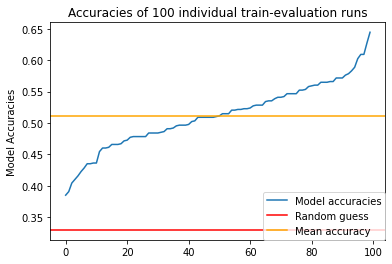

In [62]:
# plot accuracies
import matplotlib.pyplot as plt
plt.plot(sorted(accuracies), label='Model accuracies')
plt.axhline(y=0.33, color='r', linestyle='-', label='Random guess')
plt.axhline(y=sum(accuracies)/runs, color='orange', linestyle='-', label='Mean accuracy')
plt.ylabel('Model Accuracies')
plt.title(f"Accuracies of {runs} individual train-evaluation runs")
plt.legend(loc="lower right", borderaxespad=0)
# plt.savefig(PATH_PERFORMANCE_GRAPH)
plt.show()

In [33]:

#load weights
path='saved_weights/deep_classifier_04.pt'
model.load_state_dict(torch.load(path));
model.eval();

#inference

In [34]:
def predict_sentence(model, sentence):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]  #tokenize the sentence
    return predict(model, tokenized)


def predict(model, tokenized):
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]          #convert to integer sequence
    length = [len(indexed)]                                    #compute no. of words
    tensor = torch.LongTensor(indexed).to(device)              #convert to tensor
    tensor = tensor.unsqueeze(1).T                             #reshape in form of batch,no. of words
    length_tensor = torch.LongTensor(length)                   #convert to tensor
    prediction = model(tensor, length_tensor)                  #prediction
    return prediction

tens = predict_sentence(model, "Ich bin ein Lockdown.")


In [ ]:
#make predictions
sentence = "Ich bin ein Lockdown."
probs = predict_sentence(model, sentence)
label = LABEL.vocab.itos[torch.argmax(probs)]
print(sentence + " => " + label)

In [ ]:
# determine validation accuracy
correct = 0
total = 0
for e in valid_data:
    # print(getattr(e,'label'))
    # print(getattr(e, 'text'))
    target_label = getattr(e, 'label')
    tokenized_sentence = getattr(e, 'text')
    preds = predict(model, tokenized_sentence)
    pred_label = LABEL.vocab.itos[torch.argmax(preds)]
    if pred_label == target_label:
        correct += 1
    total += 1

accuracy = correct / total

In [ ]:

print(model)